# Report

In [1]:
import numpy as np
import pandas as pd
import copy
import geopandas as gpd
import plotly.graph_objs as go
import plotly as py
from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib as mpl
from scipy.stats import norm
from itertools import repeat
from numpy.random import normal
from scipy.stats import ttest_1samp

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# init_notebook_mode()
plt.rcParams["figure.figsize"] = (10,5)

# Introduction

The U.S. government incarcerates over 1,500,000 inmates in the prison system, which is the largest in the world and keeps growing. Amid concerns about the unsustainable growth of our prison system, begging in the 1980s, prison privatization became a booming industry under government programs to cut back on the federal workforce. The Justice Departments has been contracting private prison corporations for the incarceration of prisoners.

To provide clients of the private prison industry a status report of the current market, this project aims to survey the prisoner population dynamics of the U.S. justice and correction system, and summarize the longitudinal trends of incarceration. A forecast model is built by learning the pattern presented in past data and to predict change of the prisoner population in the future. This study can offer important information for business decision for clients and investors in the prison industry, such as regional expansion of revenue and contract for operation of custody facilities in the future.

# Preparing the data

## Load region and state names

Names of U.S. jurisdictions (states) and their abbreviation are organized into a DataFrame. The abbreviation will be used as geological labels for visualizing data in the form of a map.

In [4]:
states = pd.read_excel("./messy_data/states.xlsx")
# Delete District of Columbia and add a Abbraviation FED for Federal,
# because DC is underneath the Federal jurisdiction.
states.drop(states.index[states.Abbreviation == "DC"], inplace=True)
states.columns = ["Jurisdiction", "Jurisdiction Abbreviation"]
states = states.append({"Jurisdiction" : "Federal", "Jurisdiction Abbreviation" : "FED"}, ignore_index=True)
states.tail()

,Jurisdiction,Jurisdiction Abbreviation
47,West Virginia,WV
48,Wisconsin,WI
49,Wyoming,WY
50,Puerto Rico,PR
51,Federal,FED


The U.S. Census Bureau divides the country into 4 regions -- Northeast, Midwest, South and West. Each region is futhre divided into several divisions. These nomenclatures are used to generate regional aggregations of the data.

In [5]:
regions = pd.read_excel("./messy_data/state_region.xlsx")
# Drop District of Columbia.
regions.drop(regions.index[regions.State == "District of Columbia"], inplace=True)
regions.head()

,State,Division,Region
0,Connecticut,New England,Northeast
1,Maine,New England,Northeast
2,Massachusetts,New England,Northeast
3,New Hampshire,New England,Northeast
4,Rhode Island,New England,Northeast


## Load prisoner population data

The U.S. Bureau of Justice Statistics surveys the inmates annually and publishes the Prisoners In XXXX series, reporting the demographics of the U.S. prisoner population. They congregate the data in both federal and states’ male and female prison system. The data table is then melted to an analysis-ready and clean format with rows representing observation while columns indicates variables.

In [6]:
malePrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Male", header=9, nrows=54).dropna(1, "all").dropna(0)
femalePrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Female", header=9, nrows=54).dropna(1, "all").dropna(0)
totalPrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Total", header=9, nrows=54).dropna(1, "all").dropna(0)

In [7]:
def cleanPopulationTable(table, states):
    
    # add DC data to Federal, and delete it
    table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] = table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] + table.loc[table.Jurisdiction == "District of Columbia"].iloc[:, 1:].replace("--", 0)
    table.drop(table.index[table.Jurisdiction == "District of Columbia"], inplace=True)
    
    meltedTable = table.melt(id_vars = "Jurisdiction", var_name = "Year", value_name = "Population")
    
    table.set_index("Jurisdiction", inplace=True)
    table.columns = table.columns.astype(np.int)
    table.columns.name = "Year"
    table = table.astype(np.float)
    
    return table, meltedTable

Originally, District of Columbia was treated as an independent jurisdiction in Bureau of Justice Statistics's survey. However, as of 2001, it is being considered as part of the federal jurisdiction. This created some missing values for the District of Columbia data and the federal data starting in 2001. To correct for the inconsistency, the District of Comubia data prior to 2001 is added into the federal prisoner population during data cleaning.

In [8]:
malePrisonerPopulation, malePrisonerPopulation_melted = cleanPopulationTable(malePrisonerPopulation, states)
femalePrisonerPopulation, femalePrisonerPopulation_melted  = cleanPopulationTable(femalePrisonerPopulation, states)
totalPrisonerPopulation, totalPrisonerPopulation_melted = cleanPopulationTable(totalPrisonerPopulation, states)

In [9]:
totalPrisonerPopulation.head()

Year,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Jurisdiction,,,,,,,,,,,,,,,,,,,,,
Federal,29803.0,26371.0,24363.0,28133.0,29673.0,31926.0,34263.0,40223.0,44408.0,48300.0,...,199618.0,201280.0,208118.0,209771.0,216362.0,217815.0,215866.0,210567.0,196455.0,189192.0
Alabama,5625.0,5464.0,6543.0,7657.0,9233.0,9856.0,10482.0,11015.0,11710.0,12827.0,...,29412.0,30508.0,31874.0,31764.0,32270.0,32431.0,32381.0,31771.0,30810.0,28883.0
Alaska,712.0,760.0,822.0,1024.0,1322.0,1631.0,1967.0,2329.0,2460.0,2528.0,...,5167.0,5014.0,5285.0,5391.0,5597.0,5633.0,5081.0,5794.0,5338.0,4434.0
Arizona,3456.0,3749.0,4372.0,5223.0,6069.0,6889.0,7845.0,8531.0,9434.0,10948.0,...,37746.0,39502.0,40544.0,40209.0,40020.0,40080.0,41177.0,42259.0,42719.0,42320.0
Arkansas,2654.0,3042.0,2911.0,3328.0,3922.0,4246.0,4482.0,4611.0,4701.0,5441.0,...,14314.0,14716.0,15208.0,16204.0,16108.0,14654.0,17235.0,17874.0,17707.0,17537.0


In [10]:
totalPrisonerPopulation_melted.head()

,Jurisdiction,Year,Population
0,Federal,1978,29803
1,Alabama,1978,5625
2,Alaska,1978,712
3,Arizona,1978,3456
4,Arkansas,1978,2654


The data are then visualized in a U.S. map, with pseudo-color indicating the prison population in each geological jurisdiction.

In [11]:
def plotAnnualStatePopulation(table, gender, years_chosen):
    
    table = states.merge(table, on="Jurisdiction")
    table = table[table.Jurisdiction != "Federal"]

    cmax = table.Population.max()
    cmin = table.Population.min()
    
    years = table.Year.unique()

    heatMapData = [{"type" : "choropleth",  "locations" : table.loc[table.Year == year, "Jurisdiction Abbreviation"], "locationmode" : "USA-states", "colorscale" : "Viridis", "zmin" : cmin, "zmax" : cmax, "z" : table.Population[table.Year == year].astype(float)} for year in years]
    mapLayout = [{"geo" : {"scope" : 'usa'}, "title" : gender + " Prisoner Population by State, " + str(year)} for year in years]
    
    for i, data in enumerate(heatMapData):
        if years[i] in years_chosen:
            usHeatMap = go.Figure(data=[data], layout=mapLayout[i])
#             iplot(usHeatMap)
            usHeatMap.show(renderer="svg")

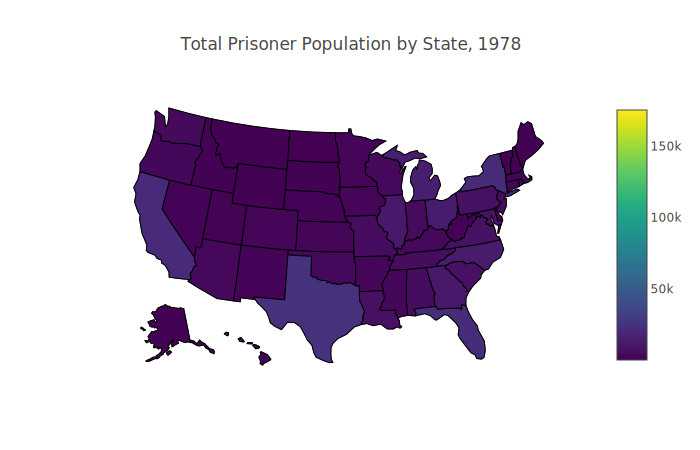

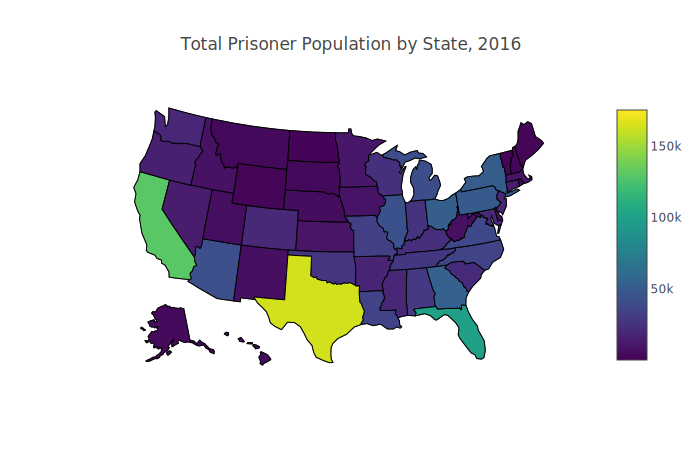

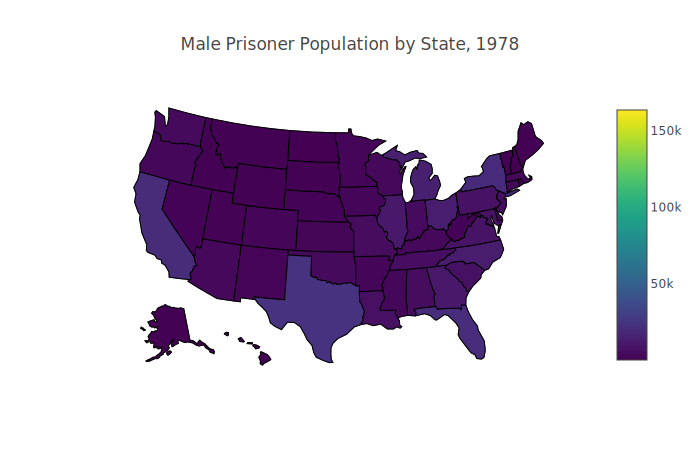

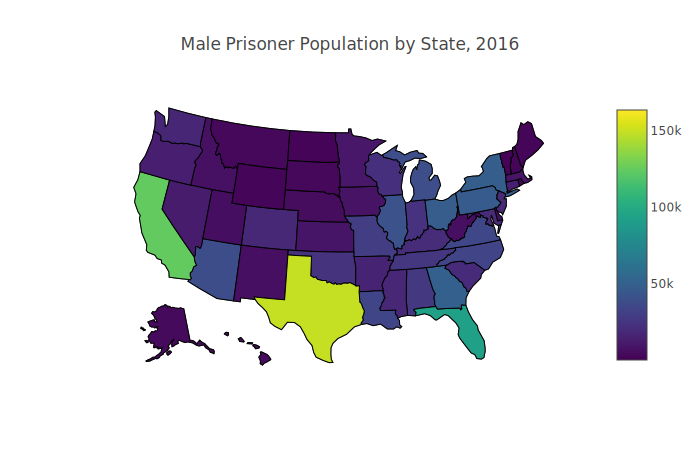

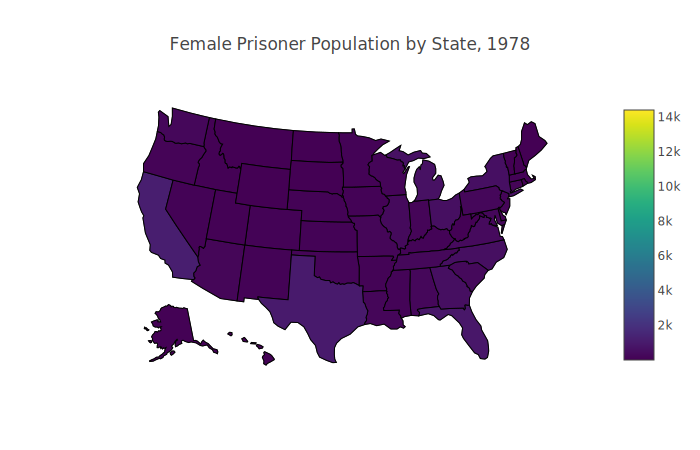

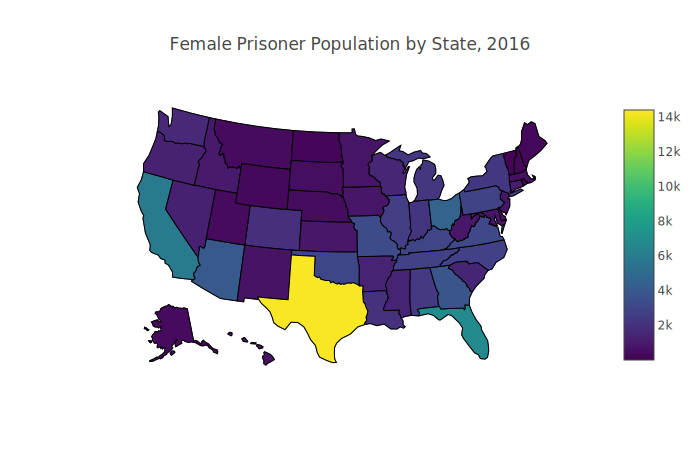

In [12]:
plotAnnualStatePopulation(totalPrisonerPopulation_melted, "Total", [1978, 2016])
plotAnnualStatePopulation(malePrisonerPopulation_melted, "Male", [1978, 2016])
plotAnnualStatePopulation(femalePrisonerPopulation_melted, "Female", [1978, 2016])

Compared to the data in 1978, the prisoner population in most jurisdictions has increased in both the male and female systems considerably as far as the 2016 data show. The elevation is especially prominent in California, Texas and Florida.

## Load admission and release data

The U.S. Bureau of Justice Statistics also surveys the statistics about annual admission and release in each jurisdiction. These data are very important in terms of building a model that accounts for the temporal dynamics of the prisoner population.

In [13]:
maleAdmission = pd.read_excel("./messy_data/admissions.xlsx", sheet_name="Male").dropna().replace("/", np.nan)
maleRelease = pd.read_excel("./messy_data/releases.xlsx", sheet_name="Male").dropna().replace("/", np.nan)

femaleAdmission = pd.read_excel("./messy_data/admissions.xlsx", sheet_name="Female").dropna().replace("/", np.nan)
femaleRelease = pd.read_excel("./messy_data/releases.xlsx", sheet_name="Female").dropna().replace("/", np.nan)

totalAdmission = pd.read_excel("./messy_data/admissions.xlsx", sheet_name="Total").dropna().replace("/", np.nan)
totalRelease = pd.read_excel("./messy_data/releases.xlsx", sheet_name="Total").dropna().replace("/", np.nan)

In [14]:
def cleanCountTable(table, states, tableType):
    
    table.replace([".", "/"], [np.nan, np.nan], inplace=True)
    
    for i, row in table.iterrows():
        if row.isnull().any():
            table.loc[i, 1 :] = pd.to_numeric(row.iloc[1 :]).interpolate()
    
    # add DC data to Federal, and delete it
    table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] = table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] + table.loc[table.Jurisdiction == "District of Columbia"].iloc[:, 1:].replace("--", 0)
    table.drop(table.index[table.Jurisdiction == "District of Columbia"], inplace=True)
    
    meltedTable = table.melt(id_vars = "Jurisdiction", var_name = "Year", value_name = tableType)
    
    table.set_index("Jurisdiction", inplace=True)
    table.columns = table.columns.astype(np.int)
    table.columns.name = "Year"
    table = table.astype(np.float)
    
    return table, meltedTable

The inconsistency that involves the District of Columbia and federal numbers, as pointed out for the population data above, also exists for the annual admission and release data. It is corrected in the same fashion as mentioned before.

Some jurisdiction also failed to report their data during certain years. The corresponding missing values are interpolated linearly.

In [15]:
maleAdmission, maleAdmission_melted = cleanCountTable(maleAdmission, states, "Admission")
maleRelease, maleRelease_melted = cleanCountTable(maleRelease, states, "Release")

femaleAdmission, femaleAdmission_melted = cleanCountTable(femaleAdmission, states, "Admission")
femaleRelease, femaleRelease_melted = cleanCountTable(femaleRelease, states, "Release")

totalAdmission, totalAdmission_melted = cleanCountTable(totalAdmission, states, "Admission")
totalRelease, totalRelease_melted = cleanCountTable(totalRelease, states, "Release")

In [16]:
totalAdmission.head()

Year,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Jurisdiction,,,,,,,,,,,,,,,,,,,,,
Federal,14724.0,14120.0,12598.0,12830.0,14818.0,16745.0,16013.0,17916.0,18501.0,18709.0,...,53618.000000,53662.000000,56153.000000,54121.0,60634.0,55938.0,53664.0,50865.0,46912.0,44682.0
Alabama,2572.0,2597.0,3766.0,4025.0,4425.0,4605.0,4701.0,4370.0,3962.0,4543.0,...,10708.000000,11037.000000,13093.000000,11881.0,11387.0,11203.0,11265.0,10912.0,10451.0,10749.0
Alaska,258.0,311.0,459.0,461.0,541.0,711.0,727.0,875.0,1097.0,952.0,...,2716.428571,2694.285714,2672.142857,2650.0,3789.0,3906.0,3906.0,3846.0,4271.0,1804.0
Arizona,1620.0,1641.0,2082.0,2759.0,2910.0,3288.0,3386.0,3989.0,4515.0,5370.0,...,14046.000000,14867.000000,14526.000000,13249.0,13030.0,12970.0,13538.0,14439.0,14670.0,13663.0
Arkansas,1958.0,2189.0,2311.0,2419.0,2323.0,2173.0,2179.0,2301.0,2280.0,3152.0,...,6651.000000,7017.000000,7383.000000,7603.0,7059.0,5782.0,8987.0,9435.0,9351.0,9911.0


In [17]:
totalAdmission_melted.head()

,Jurisdiction,Year,Admission
0,Federal,1978,14724
1,Alabama,1978,2572
2,Alaska,1978,258
3,Arizona,1978,1620
4,Arkansas,1978,1958


## Aggregate and sum regional/divisional population, admission and release

The annual population, admission and release data are aggregated to reflect the sum in regions and divisions according to the U.S. Census Bureau's framework. The aggregation makes it possible to model the data on a regional level.

In [18]:
def aggregateRegionalPopulationSum(meltedTable, regions):
    
    meltedTable = regions.merge(meltedTable, left_on="State", right_on="Jurisdiction", how="right")
    temp_index = meltedTable["Jurisdiction"] == "Federal"
    meltedTable.loc[temp_index, "Region"] = "Federal"
    meltedTable.loc[temp_index, "Division"] = "Federal"
    
    regionSum = meltedTable.groupby(["Year", "Region"]).Population.sum().unstack(0)
    divisionSum = meltedTable.groupby(["Year", "Region", "Division"]).Population.sum().unstack(0)
    
    return regionSum, divisionSum

In [19]:
malePrisonerPopulationRegionSum, malePrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(malePrisonerPopulation_melted, regions)
femalePrisonerPopulationRegionSum, femalePrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(femalePrisonerPopulation_melted, regions)
totalPrisonerPopulationRegionSum, totalPrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(totalPrisonerPopulation_melted, regions)

In [20]:
totalPrisonerPopulationRegionSum

Year,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Region,,,,,,,,,,,,,,,,,,,,,
Federal,29803.0,26371.0,24363.0,28133.0,29673.0,31926.0,34263.0,40223.0,44408.0,48300.0,...,199618.0,201280.0,208118.0,209771.0,216362.0,217815.0,215866.0,210567.0,196455.0,189192.0
Midwest,61657.0,63615.0,66211.0,73216.0,78312.0,81853.0,85664.0,95577.0,103011.0,111123.0,...,263039.0,264314.0,261615.0,263485.0,262544.0,264758.0,267095.0,267116.0,263996.0,258805.0
Northeast,42236.0,43726.0,45796.0,53908.0,59325.0,64640.0,70498.0,75591.0,82364.0,91210.0,...,179001.0,178642.0,177361.0,173912.0,170944.0,167648.0,166567.0,162694.0,157986.0,154166.0
South,128865.0,133455.0,143213.0,156038.0,177370.0,181395.0,187744.0,195950.0,207673.0,215180.0,...,638228.0,646030.0,651504.0,654653.0,653305.0,641155.0,644421.0,637309.0,630236.0,624803.0
West,41851.0,44317.0,47093.0,55156.0,65045.0,72697.0,79312.0,88762.0,100898.0,111626.0,...,316949.0,318016.0,316889.0,311982.0,295813.0,279021.0,283001.0,284633.0,277930.0,278431.0


In [21]:
totalPrisonerPopulationDivisionSum

Year                             1978     1979     1980     1981     1982  \
Region    Division                                                          
Federal   Federal             29803.0  26371.0  24363.0  28133.0  29673.0   
Midwest   East North Central  47664.0  49641.0  51175.0  56860.0  60027.0   
          West North Central  13993.0  13974.0  15036.0  16356.0  18285.0   
Northeast Mid-Atlantic        34142.0  34480.0  35870.0  41870.0  46644.0   
          New England          8094.0   9246.0   9926.0  12038.0  12681.0   
South     East South Central  17746.0  19292.0  21055.0  24171.0  26617.0   
          South Atlantic      72413.0  72731.0  75670.0  82341.0  93252.0   
          West South Central  38706.0  41432.0  46488.0  49526.0  57501.0   
West      Mountain            11721.0  12548.0  13141.0  15092.0  17458.0   
          Pacific             30130.0  31769.0  33952.0  40064.0  47587.0   

Year                             1983     1984      1985      1986      1987  \
Region    Division                                                             
Federal   Federal             31926.0  34263.0   40223.0   44408.0   48300.0   
Midwest   East North Central  62253.0  64639.0   72734.0   78572.0   84939.0   
          West North Central  19600.0  21025.0   22843.0   24439.0   26184.0   
Northeast Mid-Atlantic        51469.0  56562.0   60069.0   65670.0   73078.0   
          New England         13171.0  13936.0   15522.0   16694.0   18132.0   
South     East South Central  28416.0  28724.0   29515.0   31336.0   33783.0   
          South Atlantic      93182.0  96325.0  102072.0  109094.0  112121.0   
          West South Central  59797.0  62695.0   64363.0   67243.0   69276.0   
West      Mountain            19383.0  21138.0   22869.0   25401.0   28271.0   
          Pacific             53314.0  58174.0   65893.0   75497.0   83355.0   

Year                          ...      2007      2008      2009      2010  \
Region    Division            ...                                           
Federal   Federal             ...  199618.0  201280.0  208118.0  209771.0   
Midwest   East North Central  ...  197054.0  197599.0  194218.0  195052.0   
          West North Central  ...   65985.0   66715.0   67397.0   68433.0   
Northeast Mid-Atlantic        ...  135416.0  135515.0  135498.0  132927.0   
          New England         ...   43585.0   43127.0   41863.0   40985.0   
South     East South Central  ...  100567.0  102196.0  101959.0  100826.0   
          South Atlantic      ...  289414.0  293571.0  298505.0  298277.0   
          West South Central  ...  248247.0  250263.0  251040.0  255550.0   
West      Mountain            ...   99802.0  101284.0  101802.0  102506.0   
          Pacific             ...  217147.0  216732.0  215087.0  209476.0   

Year                              2011      2012      2013      2014  \
Region    Division                                                     
Federal   Federal             216362.0  217815.0  215866.0  210567.0   
Midwest   East North Central  193894.0  195291.0  196525.0  195055.0   
          West North Central   68650.0   69467.0   70570.0   72061.0   
Northeast Mid-Atlantic        130848.0  128560.0  127424.0  124802.0   
          New England          40096.0   39088.0   39143.0   37892.0   
South     East South Central  103680.0  105271.0  103901.0  100990.0   
          South Atlantic      295606.0  289461.0  288159.0  286722.0   
          West South Central  254019.0  246423.0  252361.0  249597.0   
West      Mountain            102253.0  100912.0  102806.0  103693.0   
          Pacific             193560.0  178109.0  180195.0  180940.0   

Year                              2015      2016  
Region    Division                                
Federal   Federal             196455.0  189192.0  
Midwest   East North Central  191431.0  185877.0  
          West North Central   72565.0   72928.0  
Northeast Mid-Atlantic        122074.0  119746.0  
          New Engl

In [22]:
def aggregateRegionalCountSum(meltedTable, regions, tableType):
    
    meltedTable = regions.merge(meltedTable, left_on="State", right_on="Jurisdiction", how="right")
    temp_index = meltedTable["Jurisdiction"] == "Federal"
    meltedTable.loc[temp_index, "Region"] = "Federal"
    meltedTable.loc[temp_index, "Division"] = "Federal"
    
    regionSum = meltedTable.groupby(["Year", "Region"])[tableType].sum().unstack(0)
    divisionSum = meltedTable.groupby(["Year", "Region", "Division"])[tableType].sum().unstack(0)
    
    return regionSum, divisionSum

In [23]:
maleAdmissionRegionSum, maleAdmissionDivisionSum = aggregateRegionalCountSum(maleAdmission_melted, regions, "Admission")
maleReleaseRegionSum, maleReleaseDivisionSum = aggregateRegionalCountSum(maleRelease_melted, regions, "Release")

femaleAdmissionRegionSum, femaleAdmissionDivisionSum = aggregateRegionalCountSum(femaleAdmission_melted, regions, "Admission")
femaleReleaseRegionSum, femaleReleaseDivisionSum = aggregateRegionalCountSum(femaleRelease_melted, regions, "Release")

totalAdmissionRegionSum, totalAdmissionDivisionSum = aggregateRegionalCountSum(totalAdmission_melted, regions, "Admission")
totalReleaseRegionSum, totalReleaseDivisionSum = aggregateRegionalCountSum(femaleRelease_melted, regions, "Release")

## Load prison occupancy data

The Bureau of Justice Statistics also provides reports about the correction facility occupancy for the 2010s. Occupancy rate is defined as the ratio of prisoner population to the capacity of the facilities. 

In [24]:
occupancyLowRate_11_16 = pd.read_excel("./messy_data/Prison occupation rate.xlsx", "Highest Capacity", na_values="/")
occupancyHighRate_11_16 = pd.read_excel("./messy_data/Prison occupation rate.xlsx", "Lowest Capacity", na_values="/")

In [25]:
def cleanAndMeltCustodyOccupancyTable(table, states):
    
    table = table.melt(id_vars = "Jurisdiction", var_name = "Year", value_name = "Occupancy")
    table.Occupancy = table.Occupancy / 100
    
    table.Year = table.Year.astype(int)
    
    
    return table

In [26]:
meltedOccupancyLowRate_11_16 = cleanAndMeltCustodyOccupancyTable(occupancyLowRate_11_16, states)
meltedOccupancyHighRate_11_16 = cleanAndMeltCustodyOccupancyTable(occupancyHighRate_11_16, states)

In [27]:
def plotAnnualStateOccupancy(table, low_or_high, years_chosen):
    
    table = states.merge(table, on="Jurisdiction")
    table = table[table.Occupancy != "Federal"]

    cmax = table.Occupancy.max()
    cmin = table.Occupancy.min()
    
    years = table.Year.unique()

    heatMapData = [{"type" : "choropleth",  "locations" : table.loc[table.Year == year, "Jurisdiction Abbreviation"], "locationmode" : "USA-states", "colorscale" : "Viridis", "zmin" : cmin, "zmax" : cmax, "z" : table.Occupancy[table.Year == year].astype(float)} for year in years]
    mapLayout = [{"geo" : {"scope" : 'usa'}, "title" : "Prison Occupancy (" + low_or_high + " Estimation) by State, " + str(year)} for year in years]
    
    for i, data in enumerate(heatMapData):
        if years[i] in years_chosen:
            usHeatMap = go.Figure(data=[data], layout=mapLayout[i])
#             iplot(usHeatMap)
            usHeatMap.show(renderer="svg")

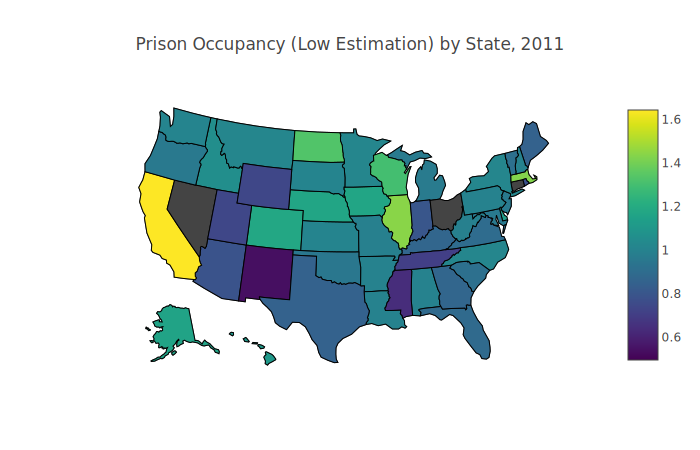

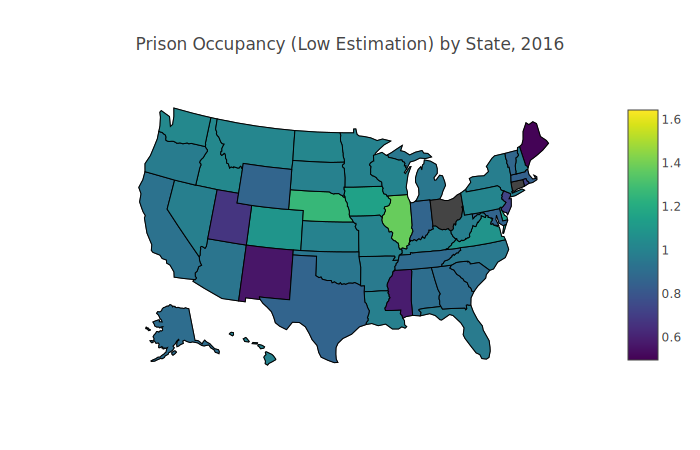

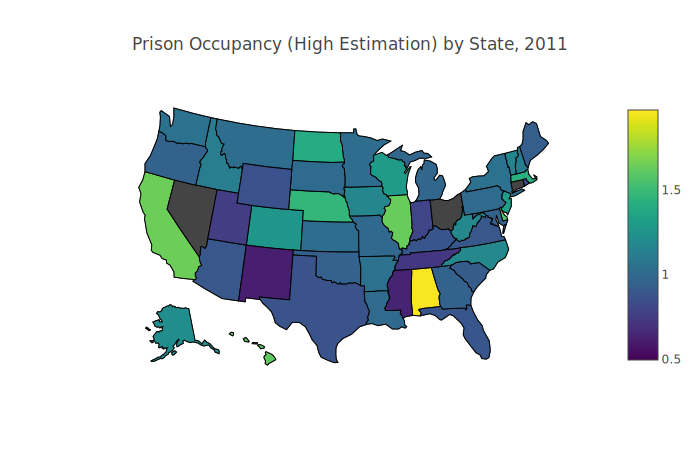

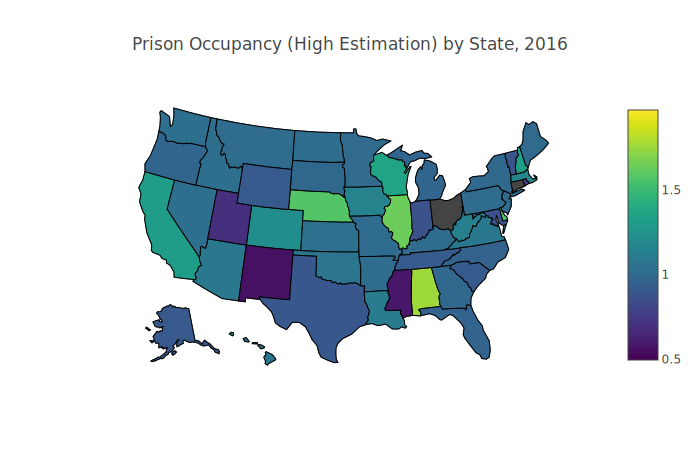

In [28]:
plotAnnualStateOccupancy(meltedOccupancyLowRate_11_16, "Low", [2011, 2016])
plotAnnualStateOccupancy(meltedOccupancyHighRate_11_16, "High", [2011, 2016])

The data suggest during the second decade of the 21st century, the occupancy rate of U.S. prisons are reducing. This is especially true for some states such as California. However, for many states, their prisons are still operating over 100% of its capacity.

## Load and aggregate prison capacity data

As the forecast model is able to predict future prisoner population. It can be divided by the current capacity to make projection about the future prison ocuupancy rate, if no new facility is being built in the future.

In [29]:
capacity = pd.read_excel("./messy_data/facility capacity 2016.xlsx").replace(["…", "/"], np.nan)
capacity = capacity.set_index("Jurisdiction").max(axis=1)
capacity.dropna(inplace=True)
capacity = capacity.astype(np.float)
capacity.name = "Capacity"
capacity.head()

Jurisdiction
Federal     135334.0
Alabama      25784.0
Alaska        4838.0
Arizona      44831.0
Arkansas     16449.0
Name: Capacity, dtype: float64

The data are also aggregated and summed to reflect prison capacity on a regional level.

In [30]:
capacitySum = regions.merge(capacity, left_on="State",right_on="Jurisdiction")
capacitySum.columns = ["Jurisdiction", "Division", "Region", "Capacity"]
capacitySum.iloc[-1] = ["Federal", "Federal", "Federal", capacity["Federal"]]
capacitySum = capacitySum[["Region", "Division", "Jurisdiction", "Capacity"]]

capacityRegionSum = capacitySum.groupby(["Region"]).Capacity.sum()
capacityDivisionSum = capacitySum.groupby(["Region", "Division"]).Capacity.sum()

In [31]:
capacityRegionSum

Region
Federal      135334.0
Midwest      194841.0
Northeast    145842.0
South        561824.0
West         248834.0
Name: Capacity, dtype: float64

In [32]:
capacityDivisionSum

Region     Division          
Federal    Federal               135334.0
Midwest    East North Central    126930.0
           West North Central     67911.0
Northeast  Mid-Atlantic          122113.0
           New England            23729.0
South      East South Central     77048.0
           South Atlantic        270211.0
           West South Central    214565.0
West       Mountain               98390.0
           Pacific               150444.0
Name: Capacity, dtype: float64

## Load average sentencing data

The U.S. Sentencing Commission is an independent agency of the judicial branch of the federal government. It composes the sentencing guidelines for the U.S. federal courts. It also publishes annual statistics pertaining to the criminal case sentencing. They survey the average national sentencing every year.

In [33]:
annualSentence = pd.read_excel("./messy_data/national sentencing.xlsx").iloc[:, [0,1]]
annualSentence.columns = ["Year", "Sentence"]
annualSentence.set_index("Year", inplace=True)
annualSentence = annualSentence.iloc[:-1,0]

Text(0.5, 1.0, 'Average National Sentencing')

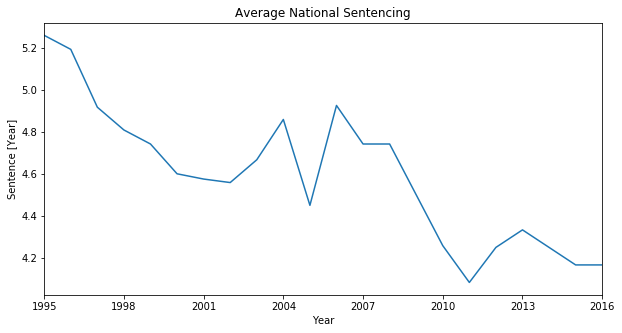

In [34]:
annualSentence.plot()
plt.xticks(np.array(range(1995, 2017, 3)))
plt.ylabel("Sentence [Year]")
plt.title("Average National Sentencing")

This project uses the average national sentencing data spanning from 1995 to 2016 to build a model that can indicate sentencing statistics in the future. It seems that at the national level, sentences are getting shorter. However, it is difficult to justify building a model that is centered around the idea of a more lenient justice system in the long run because only a limited number of data points are available, making it impossibe to distinguish whether this trend is merely a short-term adjustment or a sustained effect. Thus, a normal distribution is adopted to sample future sentences.

# Forecast model

Given data of annual population $p[t]$, admission $a[t]$ and release $r[t]$, we can model the yearly dynamics of prisoner population with a first degree difference stochastic process
$$p[t] - p[t - 1] = a[t] - r[t] + \varepsilon p[t - 1], \varepsilon  \sim N(0,\delta^2 )$$
where $\varepsilon p[t - 1]$ is the Gaussian error term and $\varepsilon$ indicates the error is proportional to the previous population. $\varepsilon$ should be zero-centered with a variance of $\delta^2$.

Every year it is assumed that any prisoner's remaining sentence to serve is also a random variable $s[t]$ which is normally distributed. The center of that distribution is year-dependent and denoted $\mu [t]$, while the variance $\sigma^2$ is assumed to be invariate. The annual release can be approximated with such distribution's cumulative distribution function
$$r[t] = F(1;\mu [t - 1],{\sigma ^2})p[t - 1]$$
$F(1)$ represents the proportion of prisoners whose remaining sentence is less than 1 year.

A second degree difference equation is used to describe the temporal evolution of the combined remaining sentence  of the whole prisoner body
$$p[t]\mu [t] = p[t - 1](\mu [t - 1] - 1) + 0.5r[t] + a[t]y[t] - 0.5a[t]$$
$p[t - 1](\mu [t - 1] - 1)$ represents the previous year's population's average number of remaining years to serve reduces for by 1 year. However, because $r[t]$ prisoners are being released, 1 year of decrease is an over-estimation. On average, for each prisoner released, a half-year over-estimation is introduced. Thus, it is compensated by the $+0.5r[t]$ term given the prisoners are released evenly throughout the year. $y[t]$ is the average sentence of the admitted prisoner of that year. $a[t]y[t]$ represents the contribution of the newly admitted prisoners. Similarly, for each newly admitted prisoner, because the individual will have served some time by the end of the year, we introduced a half-year over-estimation, which is corrected by the $-0.5a[t]$ term.

In [35]:
def extractAreaPopulationCount(table, area, tableType="Population", year_begin=1978,year_end=2016):
    # Extract a series of population, admission or release data for an area (state, region or division)
    # area is a pandas index
    
    data = table.loc[area]
         
    data = data[np.logical_and(data.index <= year_end, data.index >= year_begin)]
    data.name = tableType
    data.index.name="Year"
    
    return data

In [36]:
def propogateMu(past_mu,past_p, current_p, current_a,current_r, current_y):
    # State propogation function derived from the equilibrium of population * mu
    
    return (past_p * (past_mu - 1) + 0.5 * current_r + current_a * (current_y - 0.5)) / current_p

In [37]:
def solveMu(initialMu,initialPopulation, population, admission,release, anualSentence):
    # Given the initial state of mu and populatin,
    # this function can calculate the evolution of mu
    # according to the revolution of population, admission, release, and average sentence
    
    mu = population * 0
    mu.name = "Mu"

    for i, p in enumerate(population):
    
        if i == 0:
            past_p = initialPopulation
            past_mu = initialMu
        
        # propogate mu
        mu.iloc[i] = propogateMu(past_mu, past_p, population.iloc[i], admission.iloc[i],release.iloc[i], anualSentence.iloc[i])
        
        past_mu = mu.iloc[i]
        past_p = population.iloc[i]
        
    mu[1994] = initialMu
    mu = mu.sort_index()
    
    return mu

In [38]:
def estimateSigmaOfNormalCDF(x,F, mu):
    # Given x and F -- CDF at x of a normal distribution with center of mu,
    # this function estimate the square root of variance
    
    # This function can take vetor input
    
    # we have function F(x) as the CDF of N(mu, sigma^2)
    # given function Phi(x) as the CDF of N(0, 1)
    # F(x) = Phi((x - mu) / sigma)
    
    # the reverse function of Phi is norm.ppf()
    return (x - mu) / norm.ppf(F) 

In [39]:
def estimateSigma(population, release, mu): 
    # Estimate sigma given population and release data.
    # r[t] = F(1; mu, sigma^2) x p[t-1].
    # CDF is the cumulative distribution of a normal distribution.
    
    mu = mu.values[: -1]
    p = population.values[: -1]
    r = release.values

    F = r / p
    sigma = estimateSigmaOfNormalCDF(1,F, mu)
    sigma = sigma[sigma >= 0]
    
    return sigma.mean()

In [40]:
def sampleFutureAdmissionSentence(sampleMean,sampleSD, year_end, dataType):
    # Given the mean and standard deviation,
    # this function samples an array of admission or sentence from a normal distribution,
    # ranging from 2017 to year_end
    
    years = range(2017, year_end + 1)
    simulated = normal(sampleMean,sampleSD, len(years))
    simulated[simulated <= 0.] = sampleMean
    if dataType == "Admission":
        simulated = np.round(simulated)
    
    simulated = pd.Series(simulated, index=years, name=dataType)
    simulated.index.name = "Year"
    
    return simulated

In [41]:
def propogateState(past_mu,past_p, current_a,current_y, epsilon_sd, sigma):
    # State propogation function.
    # This function estimates release as PDF of a normal distribution with mu as the center.
    # The population was propogated as increment of difference between admission and release
    # plus proportional error
    
    if np.isnan(sigma):
        current_r = (- past_p + current_a * (current_y - 0.5 + past_mu)) / (past_mu - 0.5)
        # This dynamics tries to stablize mu
    else:
        current_r = np.round(norm(past_mu, sigma).cdf(1) * past_p)
    # calculate population as the increment of difference between admission and release
    current_p = np.round(past_p + current_a - current_r + normal(scale=epsilon_sd) * past_p)
    # propogate mu
    current_mu = propogateMu(past_mu,past_p, current_p, current_a,current_r, current_y)
    
    return current_mu, current_p, current_r

In [42]:
def solvePopulation(initialMu,initialPopulation, futureAdmission,futureSentence, epsilon_sd, sigma):
    # Given the initial mu (mu[2016]) and initial population (p[2016]),
    # this function uses simulated future admission and sentence data
    # to generate a projection of prision population
    
    futurePopulation = futureAdmission * 0
    futurePopulation.name = "Population"
    
    futureRelease = futureAdmission * 0
    futureRelease.name = "Release"
    
    futureMu = futureSentence * 0
    futureMu.name = "Mu"
    
    # state ptopogation
    for i, p in enumerate(futurePopulation):
        
        if i == 0:
            past_mu = initialMu
            past_p = initialPopulation
            
        futureMu.iloc[i], futurePopulation.iloc[i], futureRelease.iloc[i] = propogateState(past_mu,past_p, futureAdmission.iloc[i],futureSentence.iloc[i], epsilon_sd, sigma)
        
        past_mu = futureMu.iloc[i]
        past_p = futurePopulation.iloc[i]
        
    return futureMu, futurePopulation, futureRelease

In [43]:
def modelAndProject_NSamples_OneArea(populationTable, admissionTable,releaseTable, area, annualSentence, initialMu, projectionYear, N):
    
    # This function models the data and approximate major parameters for one jurisdiction:
    # epsilon_sd -- standard deviation for the error term,
    # sigma -- standard deviation for the distribution of remaining sentence for a random individual prisoner.
    # These parameters are then used to sample and simulate projections
    
    # Note: the population, admission and release data range -- 1978-2016
    # the anual sentencing data range -- 1995-2016
    # N is the number of samples to draw for prediction
    # initialMu is the mu[1994]
    # projectionYear is the end of projection

    
    # Estimate error term of population increment
    
    population = extractAreaPopulationCount(populationTable, area, "Population")
    admission = extractAreaPopulationCount(admissionTable, area, "Admission")
    release = extractAreaPopulationCount(releaseTable, area, "Release")
    # data range 1978-2017
    
    epsilon = (population.diff() - admission + release).values[1:] / population.values[:-1]
    epsilon_sd = epsilon.std()
    
    # Model state propogation
    
    modernPopulation = population.loc[1995 :]
    modernAdmission = admission.loc[1995 :]
    modernRelease = release.loc[1995 :]
    # data range 1995-2016
    
    # estimate mu[t]
    initialPopulation = population[1994] # use 1994 for initial population
    mu = solveMu(initialMu,initialPopulation, modernPopulation, modernAdmission,modernRelease, annualSentence)
    # solveMu already concates initial state of mu to the output
    
    # estimate sigma
    modernPopulation = population.loc[1994 :]
    # include the initial state of population

    sigma = estimateSigma(modernPopulation, modernRelease, mu)
    
    # Project to from 2017 to projectionYear
    
    # Model and sample N sets of future admission and sentence
    
    admissionSD = modernAdmission.std()
    futureAdmissions = [sampleFutureAdmissionSentence(modernAdmission.iloc[-1],admissionSD, 2050, "Admission") for i in range(N)]

    sentenceSD = annualSentence.std()
    futureSentences = [sampleFutureAdmissionSentence(annualSentence.iloc[-1],sentenceSD, 2050, "Sentence") for i in range(N)]
    
    # Project future mu, population and release
    
    futureMus, futurePopulations, futureReleases = zip(*map(solvePopulation, repeat(mu.iloc[-1]),repeat(modernPopulation.iloc[-1]), futureAdmissions,futureSentences, repeat(epsilon_sd), repeat(sigma)))
    
    futurePopulations = pd.concat(futurePopulations, axis=1)
    futureAdmissions = pd.concat(futureAdmissions, axis=1)
    futureReleases = pd.concat(futureReleases, axis=1)
    
    return futurePopulations, futureAdmissions,futureReleases

In order to make projection of the future prisoner population, unknown parameters and latent variables need to  be estimated first. 
Given past anual survey of the prisoner population, admission and release, equation $p[t] - p[t - 1] = a[t] - r[t] + \varepsilon p[t - 1]$ can be used to estimate the variance of $\varepsilon$. Provided the average sentence of the newly admitted and the initial state of $\mu [t]$ ($\mu [1994]$ due to the lack of anual sentencing data prior to 1995), equation $p[t]\mu [t] = p[t - 1](\mu [t - 1] - 1) + 0.5r[t] + a[t]y[t] - 0.5a[t]$ can be used to popogate the state of the system and resolve $\mu [t]$. After that, $r[t] = F(1;\mu [t - 1],{\sigma ^2})p[t - 1]$ is used to approximate $\sigma$ for each corresponding year. The results are then averaged to generate a point estimation of $\sigma$.

To make forecast, first, a normal distribution is built based on past admission data to sample future admission. A similar distribution is also built for the past sentencing data to generate a sampler for future sentencing. Since the system state is known for up until 2016, equation $r[t] = F(1;\mu [t - 1],{\sigma ^2})p[t - 1]$ can be used to determine the next year's release while equation $p[t] - p[t - 1] = a[t] - r[t] + \varepsilon p[t - 1]$ can be used to sample for the following year's prisoner population. Finally, using equation $p[t]\mu [t] = p[t - 1](\mu [t - 1] - 1) + 0.5r[t] + a[t]y[t] - 0.5a[t]$ to propogate $\mu [t]$, one full iteration of state evolution is completed.

# Projection of prisoner population

In [44]:
def collapseSamples(sampleTable, area):
    # Calculate the mean and standar deviation of a group of projections for one jurisdiction
    
    sampleMean = sampleTable.mean(axis=1)
    sampleMean.name = area
    
    sampleSD = sampleTable.std(axis=1)
    sampleSD.name = area
    
    return sampleMean, sampleSD

In [45]:
def modelAndProjectPopulation_NSamples(populationTable, admissionTable,releaseTable, annualSentence, initialMu, projectionYear, N):
    # Models and makes forecast N projections for all the jurisdictions
    # Return the mean and standard deviation of those N projections
    
    areas = populationTable.index
    
    futurePopulationMeans = []
    futurePopulationSDs = []
    
    futureAdmissionMeans = []
    futureAdmissionSDs = []
    
    futureReleaseMeans = []
    futureReleaseSDs = []
    
    for area in areas:
        
        futurePopulations, futureAdmissions,futureReleases = modelAndProject_NSamples_OneArea(populationTable, admissionTable,releaseTable, area, annualSentence, initialMu, projectionYear, N)
        
        futurePopulationMean, futurePopulationSD = collapseSamples(futurePopulations, area)
        futurePopulationMeans.append(futurePopulationMean)
        futurePopulationSDs.append(futurePopulationSD)
        
        futureAdmissionMean, futureAdmissionSD = collapseSamples(futureAdmissions, area)
        futureAdmissionMeans.append(futureAdmissionMean)
        futureAdmissionSDs.append(futureAdmissionSD)
        
        futureReleaseMean, futureReleaseSD = collapseSamples(futureReleases, area)
        futureReleaseMeans.append(futureReleaseMean)
        futureReleaseSDs.append(futureReleaseSD)
        
    futurePopulationMeans = pd.concat(futurePopulationMeans, axis=1).transpose()
    futureAdmissionMeans = pd.concat(futureAdmissionMeans, axis=1).transpose()
    futureReleaseMeans = pd.concat(futureReleaseMeans, axis=1).transpose()
    
    futurePopulationSDs = pd.concat(futurePopulationSDs, axis=1).transpose()
    futureAdmissionSDs = pd.concat(futureAdmissionSDs, axis=1).transpose()
    futureReleaseSDs = pd.concat(futureReleaseSDs, axis=1).transpose()
        
    return futurePopulationMeans,futurePopulationSDs, futureAdmissionMeans,futureAdmissionSDs, futureReleaseMeans,futureReleaseSDs


In [46]:
maleFuturePopulationMean_5,maleFuturePopulationSD_5, maleFutureAdmissionMean_5,maleFutureAdmissionSD_5, maleFutureReleaseMean_5,maleFutureReleaseSD_5 = modelAndProjectPopulation_NSamples(malePrisonerPopulation, maleAdmission,maleRelease, annualSentence, 5, 2050, 500)
maleFuturePopulationMean_10,maleFuturePopulationSD_10, maleFutureAdmissionMean_10,maleFutureAdmissionSD_10, maleFutureReleaseMean_10,maleFutureReleaseSD_10 = modelAndProjectPopulation_NSamples(malePrisonerPopulation, maleAdmission,maleRelease, annualSentence, 10, 2050, 500)
maleFuturePopulationMean_20,maleFuturePopulationSD_20, maleFutureAdmissionMean_20,maleFutureAdmissionSD_20, maleFutureReleaseMean_20,maleFutureReleaseSD_20 = modelAndProjectPopulation_NSamples(malePrisonerPopulation, maleAdmission,maleRelease, annualSentence, 20, 2050, 500)
maleFuturePopulationMean_40,maleFuturePopulationSD_40, maleFutureAdmissionMean_40,maleFutureAdmissionSD_40, maleFutureReleaseMean_40,maleFutureReleaseSD_40 = modelAndProjectPopulation_NSamples(malePrisonerPopulation, maleAdmission,maleRelease, annualSentence, 40, 2050, 500)

femaleFuturePopulationMean_5,femaleFuturePopulationSD_5, femaleFutureAdmissionMean_5,femaleFutureAdmissionSD_5, femaleFutureReleaseMean_5,femaleFutureReleaseSD_5 = modelAndProjectPopulation_NSamples(femalePrisonerPopulation, femaleAdmission,femaleRelease, annualSentence, 5, 2050, 500)
femaleFuturePopulationMean_10,femaleFuturePopulationSD_10, femaleFutureAdmissionMean_10,femaleFutureAdmissionSD_10, femaleFutureReleaseMean_10,femaleFutureReleaseSD_10 = modelAndProjectPopulation_NSamples(femalePrisonerPopulation, femaleAdmission,femaleRelease, annualSentence, 10, 2050, 500)
femaleFuturePopulationMean_20,femaleFuturePopulationSD_20, femaleFutureAdmissionMean_20,femaleFutureAdmissionSD_20, femaleFutureReleaseMean_20,femaleFutureReleaseSD_20 = modelAndProjectPopulation_NSamples(femalePrisonerPopulation, femaleAdmission,femaleRelease, annualSentence, 20, 2050, 500)
femaleFuturePopulationMean_40,femaleFuturePopulationSD_40, femaleFutureAdmissionMean_40,femaleFutureAdmissionSD_40, femaleFutureReleaseMean_40,femaleFutureReleaseSD_40 = modelAndProjectPopulation_NSamples(femalePrisonerPopulation, femaleAdmission,femaleRelease, annualSentence, 40, 2050, 500)

In [47]:
maleFuturePopulationRegionSumMean_5,maleFuturePopulationRegionSumSD_5, maleFutureAdmissionRegionSumMean_5,maleFutureAdmissionRegionSumSD_5, maleFutureReleaseRegionSumMean_5,maleFutureReleaseRegionSumSD_5 = modelAndProjectPopulation_NSamples(malePrisonerPopulationRegionSum, maleAdmissionRegionSum,maleReleaseRegionSum, annualSentence, 5, 2050, 500)
maleFuturePopulationRegionSumMean_10,maleFuturePopulationRegionSumSD_10, maleFutureAdmissionRegionSumMean_10,maleFutureAdmissionRegionSumSD_10, maleFutureReleaseRegionSumMean_10,maleFutureReleaseRegionSumSD_10 = modelAndProjectPopulation_NSamples(malePrisonerPopulationRegionSum, maleAdmissionRegionSum,maleReleaseRegionSum, annualSentence, 10, 2050, 500)
maleFuturePopulationRegionSumMean_20,maleFuturePopulationRegionSumSD_20, maleFutureAdmissionRegionSumMean_20,maleFutureAdmissionRegionSumSD_20, maleFutureReleaseRegionSumMean_20,maleFutureReleaseRegionSumSD_20 = modelAndProjectPopulation_NSamples(malePrisonerPopulationRegionSum, maleAdmissionRegionSum,maleReleaseRegionSum, annualSentence, 20, 2050, 500)
maleFuturePopulationRegionSumMean_40,maleFuturePopulationRegionSumSD_40, maleFutureAdmissionRegionSumMean_40,maleFutureAdmissionRegionSumSD_40, maleFutureReleaseRegionSumMean_40,maleFutureReleaseRegionSumSD_40 = modelAndProjectPopulation_NSamples(malePrisonerPopulationRegionSum, maleAdmissionRegionSum,maleReleaseRegionSum, annualSentence, 40, 2050, 500)

femaleFuturePopulationRegionSumMean_5,femaleFuturePopulationRegionSumSD_5, femaleFutureAdmissionRegionSumMean_5,femaleFutureAdmissionRegionSumSD_5, femaleFutureReleaseRegionSumMean_5,femaleFutureReleaseRegionSumSD_5 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationRegionSum, femaleAdmissionRegionSum,femaleReleaseRegionSum, annualSentence, 5, 2050, 500)
femaleFuturePopulationRegionSumMean_10,femaleFuturePopulationRegionSumSD_10, femaleFutureAdmissionRegionSumMean_10,femaleFutureAdmissionRegionSumSD_10, femaleFutureReleaseRegionSumMean_10,femaleFutureReleaseRegionSumSD_10 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationRegionSum, femaleAdmissionRegionSum,femaleReleaseRegionSum, annualSentence, 10, 2050, 500)
femaleFuturePopulationRegionSumMean_20,femaleFuturePopulationRegionSumSD_20, femaleFutureAdmissionRegionSumMean_20,femaleFutureAdmissionRegionSumSD_20, femaleFutureReleaseRegionSumMean_20,femaleFutureReleaseRegionSumSD_20 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationRegionSum, femaleAdmissionRegionSum,femaleReleaseRegionSum, annualSentence, 20, 2050, 500)
femaleFuturePopulationRegionSumMean_40,femaleFuturePopulationRegionSumSD_40, femaleFutureAdmissionRegionSumMean_40,femaleFutureAdmissionRegionSumSD_40, femaleFutureReleaseRegionSumMean_40,femaleFutureReleaseRegionSumSD_40 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationRegionSum, femaleAdmissionRegionSum,femaleReleaseRegionSum, annualSentence, 40, 2050, 500)

In [48]:
maleFuturePopulationDivisionSumMean_5,maleFuturePopulationDivisionSumSD_5, maleFutureAdmissionDivisionSumMean_5,maleFutureAdmissionDivisionSumSD_5, maleFutureReleaseDivisionSumMean_5,maleFutureReleaseDivisionSumSD_5 = modelAndProjectPopulation_NSamples(malePrisonerPopulationDivisionSum, maleAdmissionDivisionSum,maleReleaseDivisionSum, annualSentence, 5, 2050, 500)
maleFuturePopulationDivisionSumMean_10,maleFuturePopulationDivisionSumSD_10, maleFutureAdmissionDivisionSumMean_10,maleFutureAdmissionDivisionSumSD_10, maleFutureReleaseDivisionSumMean_10,maleFutureReleaseDivisionSumSD_10 = modelAndProjectPopulation_NSamples(malePrisonerPopulationDivisionSum, maleAdmissionDivisionSum,maleReleaseDivisionSum, annualSentence, 10, 2050, 500)
maleFuturePopulationDivisionSumMean_20,maleFuturePopulationDivisionSumSD_20, maleFutureAdmissionDivisionSumMean_20,maleFutureAdmissionDivisionSumSD_20, maleFutureReleaseDivisionSumMean_20,maleFutureReleaseDivisionSumSD_20 = modelAndProjectPopulation_NSamples(malePrisonerPopulationDivisionSum, maleAdmissionDivisionSum,maleReleaseDivisionSum, annualSentence, 20, 2050, 500)
maleFuturePopulationDivisionSumMean_40,maleFuturePopulationDivisionSumSD_40, maleFutureAdmissionDivisionSumMean_40,maleFutureAdmissionDivisionSumSD_40, maleFutureReleaseDivisionSumMean_40,maleFutureReleaseDivisionSumSD_40 = modelAndProjectPopulation_NSamples(malePrisonerPopulationDivisionSum, maleAdmissionDivisionSum,maleReleaseDivisionSum, annualSentence, 40, 2050, 500)

femaleFuturePopulationDivisionSumMean_5,femaleFuturePopulationDivisionSumSD_5, femaleFutureAdmissionDivisionSumMean_5,femaleFutureAdmissionDivisionSumSD_5, femaleFutureReleaseDivisionSumMean_5,femaleFutureReleaseDivisionSumSD_5 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationDivisionSum, femaleAdmissionDivisionSum,femaleReleaseDivisionSum, annualSentence, 5, 2050, 500)
femaleFuturePopulationDivisionSumMean_10,femaleFuturePopulationDivisionSumSD_10, femaleFutureAdmissionDivisionSumMean_10,femaleFutureAdmissionDivisionSumSD_10, femaleFutureReleaseDivisionSumMean_10,femaleFutureReleaseDivisionSumSD_10 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationDivisionSum, femaleAdmissionDivisionSum,femaleReleaseDivisionSum, annualSentence, 10, 2050, 500)
femaleFuturePopulationDivisionSumMean_20,femaleFuturePopulationDivisionSumSD_20, femaleFutureAdmissionDivisionSumMean_20,femaleFutureAdmissionDivisionSumSD_20, femaleFutureReleaseDivisionSumMean_20,femaleFutureReleaseDivisionSumSD_20 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationDivisionSum, femaleAdmissionDivisionSum,femaleReleaseDivisionSum, annualSentence, 20, 2050, 500)
femaleFuturePopulationDivisionSumMean_40,femaleFuturePopulationDivisionSumSD_40, femaleFutureAdmissionDivisionSumMean_40,femaleFutureAdmissionDivisionSumSD_40, femaleFutureReleaseDivisionSumMean_40,femaleFutureReleaseDivisionSumSD_40 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationDivisionSum, femaleAdmissionDivisionSum,femaleReleaseDivisionSum, annualSentence, 40, 2050, 500)

In [49]:
def plotFederalProjection_GenderPopulation(population,futurePopulation,futurePopulation_error, admission,futureAdmission,futureAdmission_error, release,futureRelease,futureRelease_error, sex,initialMu,maxPopulation):
        
    pd.concat([population, futurePopulation]).plot(color="darkorange", label="population")
    plt.fill_between(futurePopulation.index, futurePopulation - futurePopulation_error, futurePopulation + futurePopulation_error, color="darkorange", alpha=0.25)
        
    pd.concat([admission, futureAdmission]).plot(color="crimson", label="admission")
    plt.fill_between(futureAdmission.index, futureAdmission - futurePopulation_error, futureAdmission + futureAdmission_error, color="crimson", alpha=0.25)

    pd.concat([release, futureRelease]).plot(color="steelblue", label="release")
    plt.fill_between(futureRelease.index, futureRelease - futureRelease_error, futureRelease + futureRelease_error, color="steelblue", alpha=0.25)
    
    plt.axvline(1995, color="grey")
    
    plt.legend(loc="upper left")
    plt.ylim([0, maxPopulation])
    plt.ylabel("Head Count")
    plt.title("Projection of Federal " + sex + " Prisoner Population, mu[1994]=" + str(initialMu))
    
    plt.show()

In [50]:
def plotRegionalProjection_GenderPopulation(population,futurePopulation,futurePopulation_error, sex,initialMu,maxPopulation):
    
    population = population.sort_index().drop("Federal").transpose()
    futurePopulation = futurePopulation.sort_index().drop("Federal").transpose()
    futurePopulation_error = futurePopulation_error.drop("Federal").sort_index().transpose()
    
    pd.concat([population, futurePopulation]).plot()
    
    plt.gca().set_prop_cycle(None)
    for i in range(population.shape[1]):
        plt.fill_between(futurePopulation.index, futurePopulation.iloc[:, i] - futurePopulation_error.iloc[:, i], futurePopulation.iloc[:, i] + futurePopulation_error.iloc[:, i], alpha=0.25)
    
    plt.axvline(1995, color="grey")
    
    plt.legend(loc="upper left")
    plt.ylim([0, maxPopulation])
    plt.ylabel("Head Count")
    plt.title("Projection of Regional " + sex + " Prisoner Population, mu[1994]=" + str(initialMu))
    
    plt.show()

In [51]:
def alignDivisionTable(table, divisionTable, regions):
    
    regions = regions.set_index("State")

    divisionTable = divisionTable.drop("Federal")
    divisionTable = divisionTable.sort_index()
    
    table = regions.join(table).reset_index().set_index(["Region","Division", "State"]).sort_index()
    
    return table, divisionTable

In [52]:
def plotDivisionalPopulationProjection_GenderPopulation(population,futurePopulation,futurePopulation_error, divisionalPopulation,futureDivisionalPopulation,futureDivisionalPopulation_error, sex,initialMu):

    population, divisionalPopulation = alignDivisionTable(population, divisionalPopulation, regions)

    futurePopulation, futureDivisionalPopulation = alignDivisionTable(futurePopulation, futureDivisionalPopulation, regions)
    futurePopulation_error, futureDivisionalPopulation_error = alignDivisionTable(futurePopulation_error, futureDivisionalPopulation_error, regions)
    
    regionList = population.index.get_level_values(0).unique()
    for region in regionList:
    
        divisionalPopulation_1Region = divisionalPopulation.loc[region]
        futureDivisionalPopulation_1Region = futureDivisionalPopulation.loc[region]
        futureDivisionalPopulation_error_1Region = futureDivisionalPopulation_error.loc[region]
    
        plt.figure()
        pd.concat([divisionalPopulation_1Region, futureDivisionalPopulation_1Region], axis=1).transpose().plot()
        plt.legend(loc="upper left")
        plt.gca().set_prop_cycle(None)
        for index, row in futureDivisionalPopulation_1Region.iterrows():
            plt.fill_between(row.index.values, row - futureDivisionalPopulation_error_1Region.loc[index], row + futureDivisionalPopulation_error_1Region.loc[index], alpha=0.25)
        plt.axvline(1995, color="grey")
        plt.ylabel("Population")
        plt.title(region + " " + sex + " Population, mu[1994]=" + str(initialMu))
    
        population_1Region = population.loc[region]
        futurePopulation_1Region = futurePopulation.loc[region]
        futurePopulation_error_1Region = futurePopulation_error.loc[region]
    
        divisions = population_1Region.index.get_level_values(0).unique()
        for division in divisions:
        
            population_1Division = population_1Region.loc[division]
            futurePopulation_1Division = futurePopulation_1Region.loc[division]
            futurePopulation_error_1Division = futurePopulation_error_1Region.loc[division]
        
            plt.figure()
            pd.concat([population_1Division, futurePopulation_1Division], axis=1).transpose().plot()
            plt.legend(loc="upper left")
            plt.gca().set_prop_cycle(None)
            for index, row in futurePopulation_1Division.iterrows():
                plt.fill_between(row.index.values.astype(int), row - futurePopulation_error_1Division.loc[index], row + futurePopulation_error_1Division.loc[index], alpha=0.25)
            plt.ylim(bottom=0)
            plt.axvline(1995, color="grey")
            plt.ylabel("Population")
            plt.title(region + " -- " + division + " " + sex + " Population, mu[1994]=" + str(initialMu))

Here, an initial state of $\mu[1994] = 20$ is used to solve the latent variables and to estimate the parameters for both the male and female facilities, following which 250 simulations are generated and averaged to build a projection with standard deviaion plotted as shaded areas.

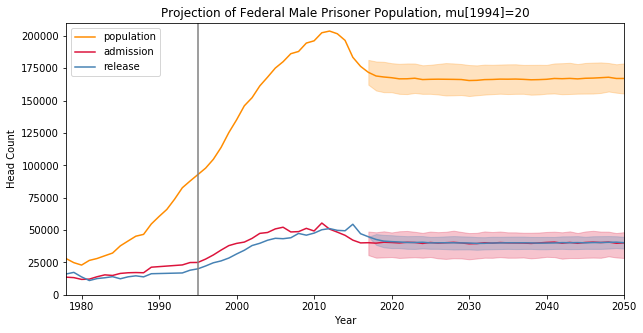

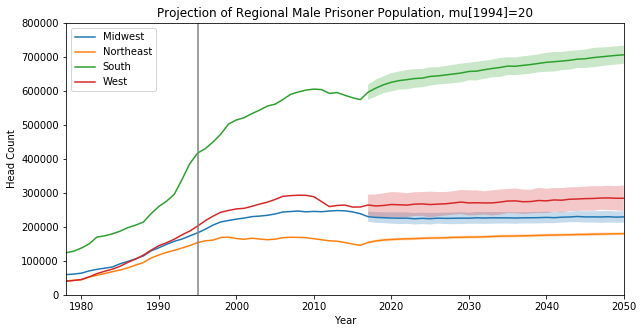

<Figure size 720x360 with 0 Axes>

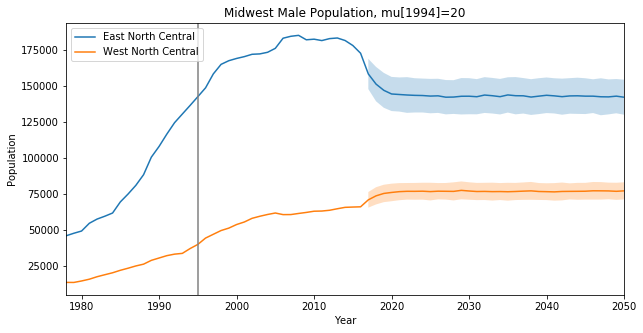

<Figure size 720x360 with 0 Axes>

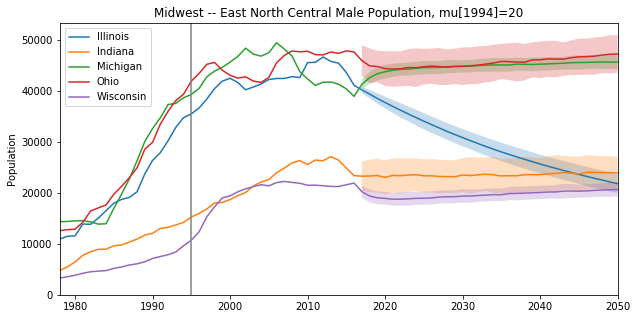

<Figure size 720x360 with 0 Axes>

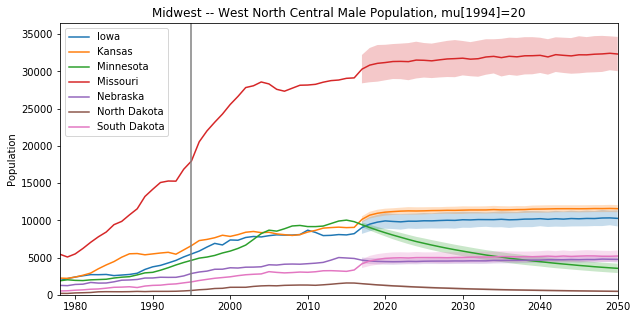

<Figure size 720x360 with 0 Axes>

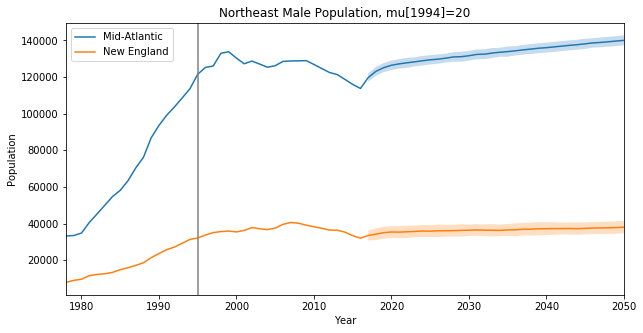

<Figure size 720x360 with 0 Axes>

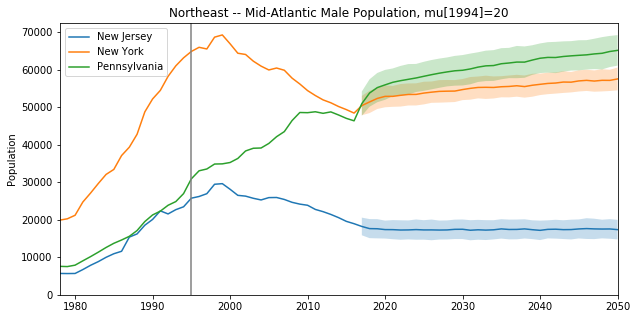

<Figure size 720x360 with 0 Axes>

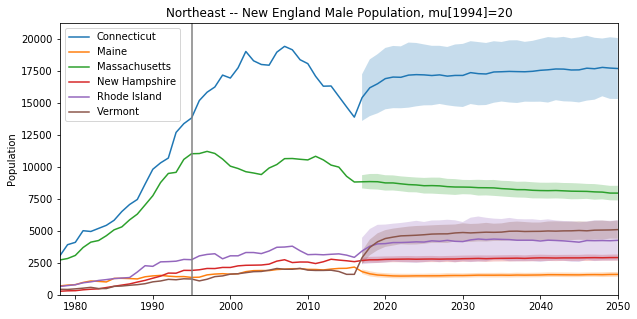

<Figure size 720x360 with 0 Axes>

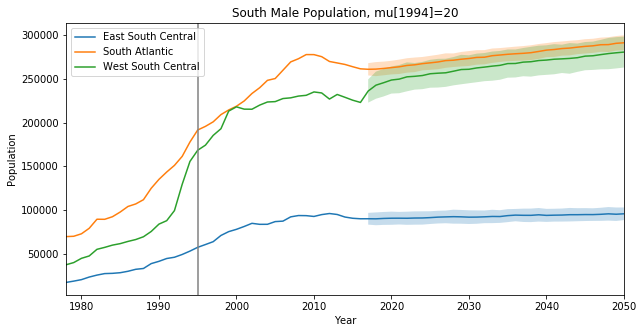

<Figure size 720x360 with 0 Axes>

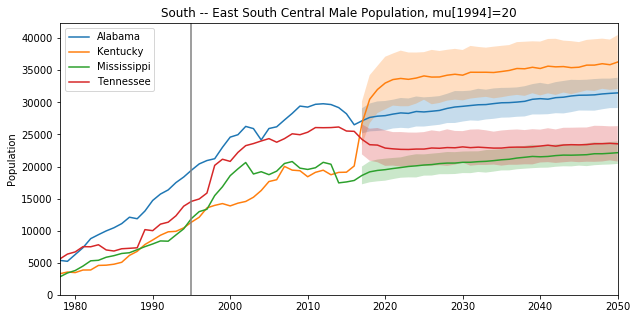

<Figure size 720x360 with 0 Axes>

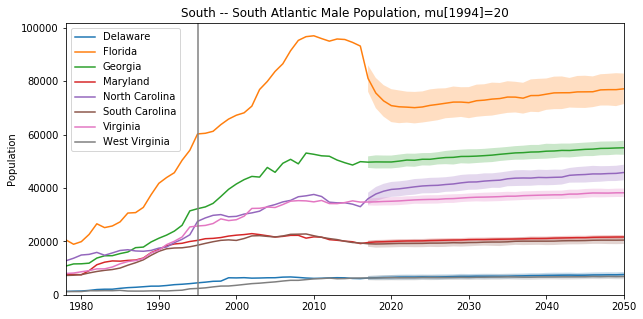

<Figure size 720x360 with 0 Axes>

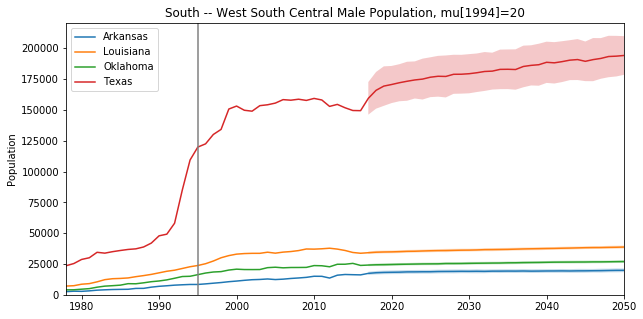

<Figure size 720x360 with 0 Axes>

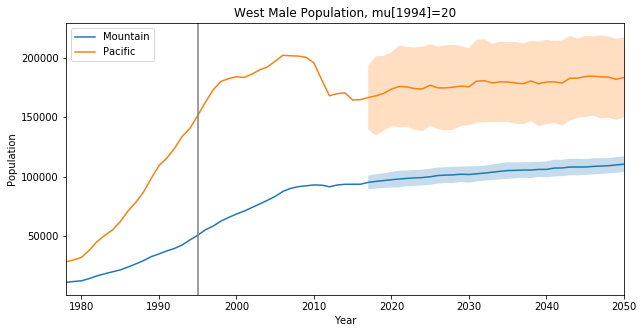

<Figure size 720x360 with 0 Axes>

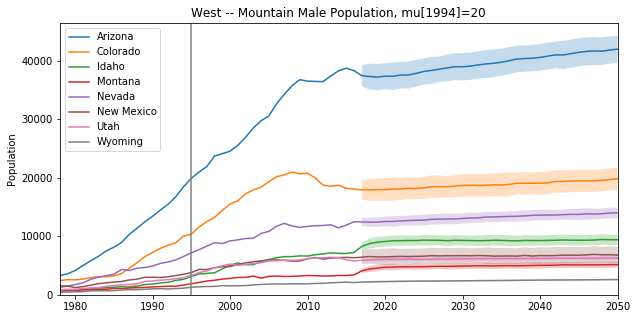

<Figure size 720x360 with 0 Axes>

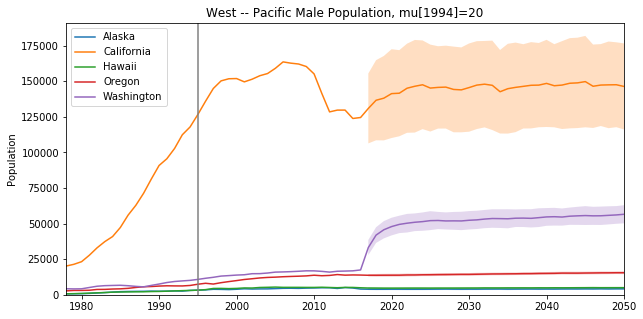

In [53]:
plotFederalProjection_GenderPopulation(malePrisonerPopulation.loc["Federal"], maleFuturePopulationMean_20.loc["Federal"],maleFuturePopulationSD_20.loc["Federal"],maleAdmission.loc["Federal"], maleFutureAdmissionMean_20.loc["Federal"],maleFutureAdmissionSD_20.loc["Federal"], maleRelease.loc["Federal"], maleFutureReleaseMean_20.loc["Federal"],maleFutureReleaseSD_20.loc["Federal"], "Male", 20, 210000)
plotRegionalProjection_GenderPopulation(malePrisonerPopulationRegionSum, maleFuturePopulationRegionSumMean_20,maleFuturePopulationRegionSumSD_20, "Male", 20, 800000)
plotDivisionalPopulationProjection_GenderPopulation(malePrisonerPopulation,maleFuturePopulationMean_20,maleFuturePopulationSD_20, malePrisonerPopulationDivisionSum,maleFuturePopulationDivisionSumMean_20,maleFuturePopulationDivisionSumSD_20, "Male",20)

The projection of federal prisoner population predicts that the male population will reach a steady state soon following the current decrease that started in mid-2010s. Among the four regions, the prisoner population of all regions but the South has entered a stable period.

In the East North Central division of the Midwest, we can expect a continuous decrease in prisoner population before it starts to stabilize in early 2020s. This decline is mostly due to the decrease of prisoner population in Illinois.

In the Northeast, the current contraction of Mid-Atlantic prisoner population will terminate by 2020, entering a slow growth which is mostly driven by a constant increase of Pennsylvania’s prisoner population.

In the south, both South Atlantic and West South Central can see a slight but continuous growth of prisoner population. In the East South Central division, Kentucky will experience a surge of growth which then transformed into a period of slow but steady development. In the West South Central, Texas continues to lead a sustained increase of prisoner population. In the south Atlantic, the current shrinkage of Florida’s prisoner body will soon enter a period very moderate but elongated expansion.

In the West, both Mountain and Pacific divisions will witness continuous but stagnant increments in their prisoner population. The increase of prisoner population in California will started to dwindle by mid-2020s, while we may expect a volatile upsurge in Washington before it is substituted with a much milder inflation.

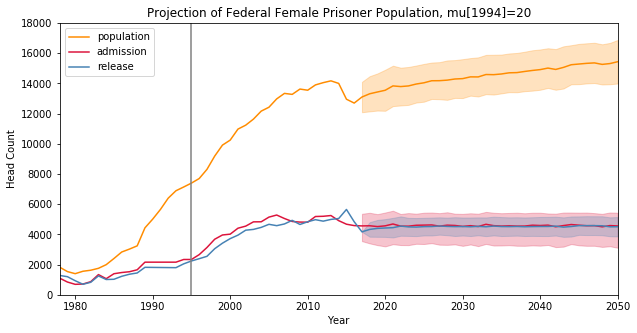

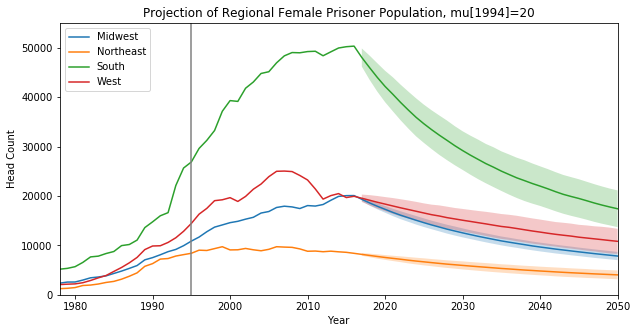

<Figure size 720x360 with 0 Axes>

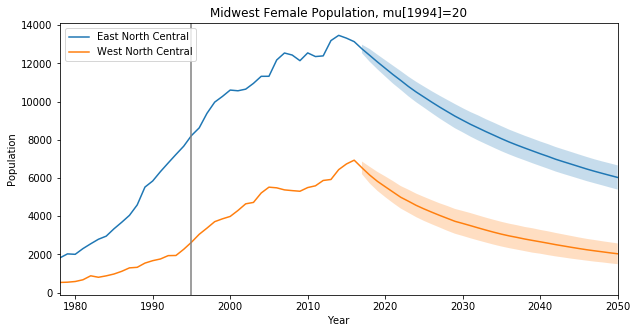

<Figure size 720x360 with 0 Axes>

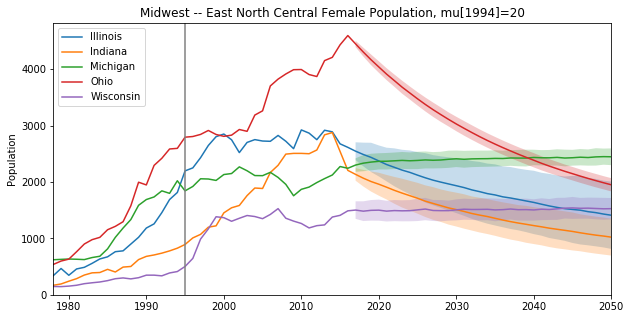

<Figure size 720x360 with 0 Axes>

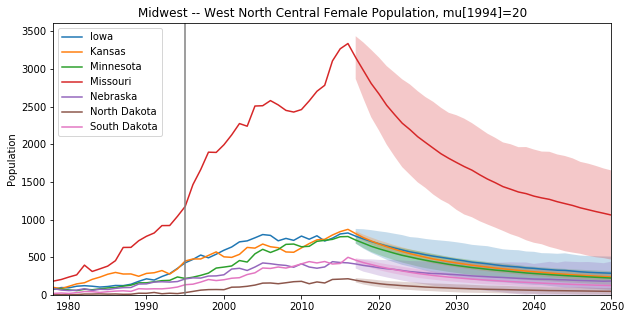

<Figure size 720x360 with 0 Axes>

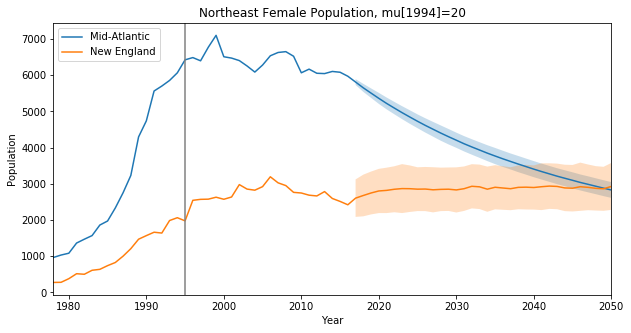

<Figure size 720x360 with 0 Axes>

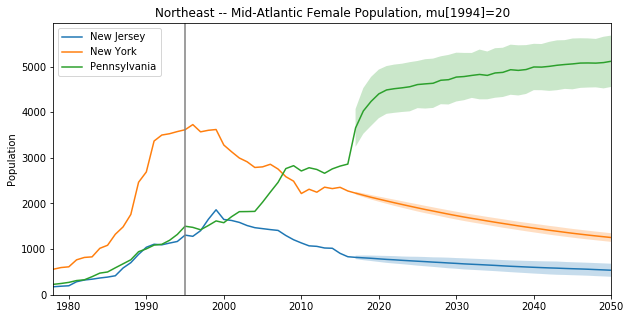

<Figure size 720x360 with 0 Axes>

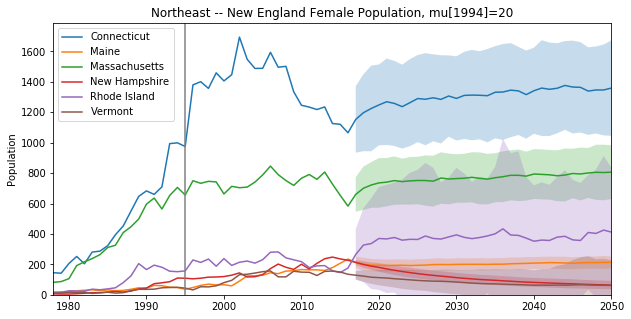

<Figure size 720x360 with 0 Axes>

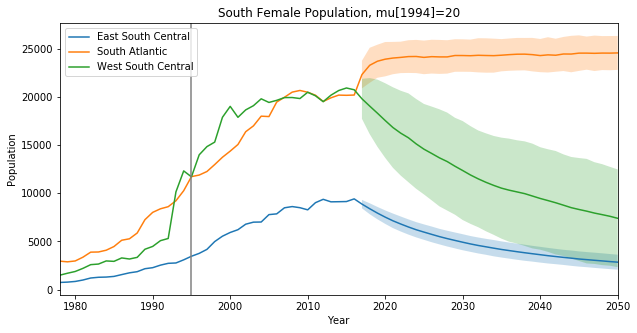

<Figure size 720x360 with 0 Axes>

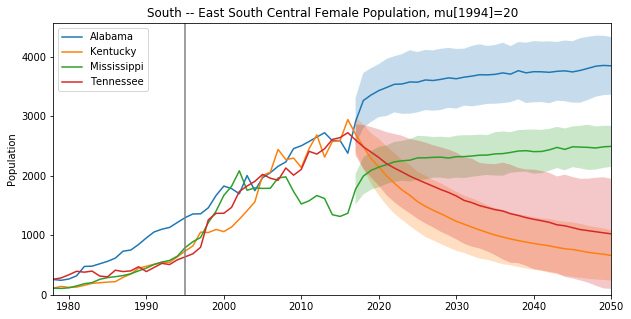

<Figure size 720x360 with 0 Axes>

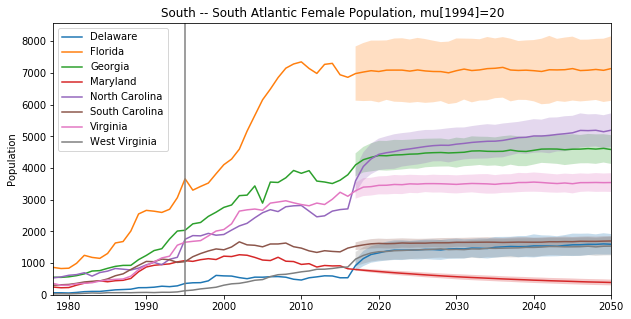

<Figure size 720x360 with 0 Axes>

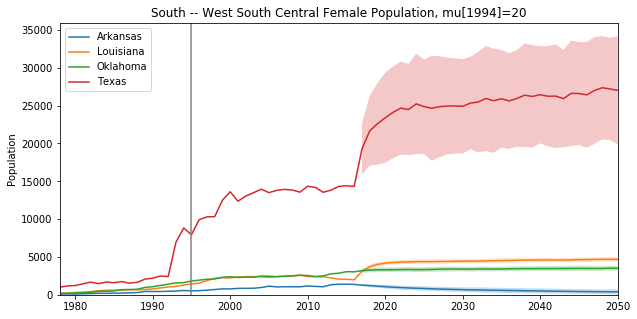

<Figure size 720x360 with 0 Axes>

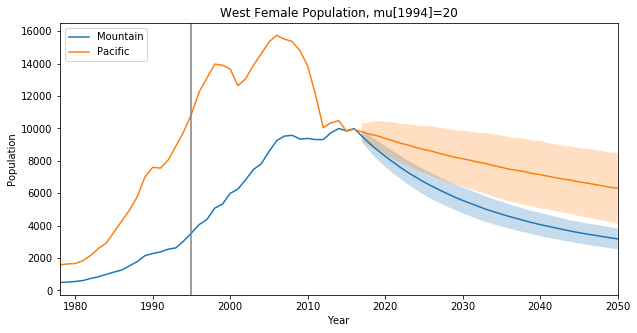

<Figure size 720x360 with 0 Axes>

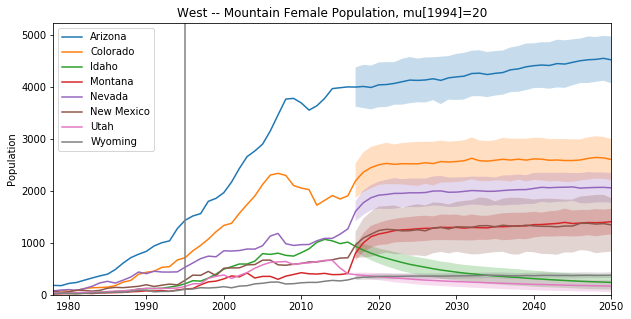

<Figure size 720x360 with 0 Axes>

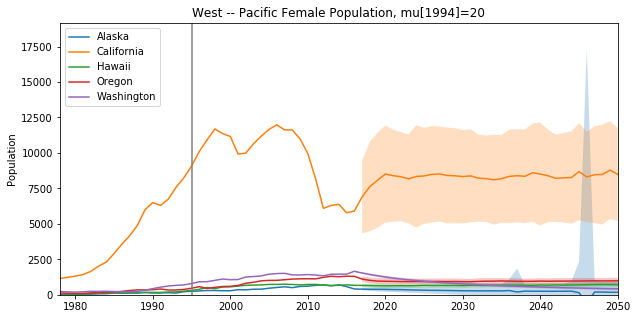

In [54]:
plotFederalProjection_GenderPopulation(femalePrisonerPopulation.loc["Federal"], femaleFuturePopulationMean_20.loc["Federal"],femaleFuturePopulationSD_20.loc["Federal"],femaleAdmission.loc["Federal"], femaleFutureAdmissionMean_20.loc["Federal"],femaleFutureAdmissionSD_20.loc["Federal"], femaleRelease.loc["Federal"], femaleFutureReleaseMean_20.loc["Federal"],femaleFutureReleaseSD_20.loc["Federal"], "Female", 20, 18000)
plotRegionalProjection_GenderPopulation(femalePrisonerPopulationRegionSum, femaleFuturePopulationRegionSumMean_20,femaleFuturePopulationRegionSumSD_20, "Female", 20, 55000)
plotDivisionalPopulationProjection_GenderPopulation(femalePrisonerPopulation,femaleFuturePopulationMean_20,femaleFuturePopulationSD_20, femalePrisonerPopulationDivisionSum,femaleFuturePopulationDivisionSumMean_20,femaleFuturePopulationDivisionSumSD_20, "Female",20)

Contradicted to the steady projected growth in the federal female prisoner population, all four regions can expect a sustained decrease in their female prisoner population. Although in most states, the female prisoner population will either maintain the current level, if not very slight increase, or experience a developing shrinkage. Pennsylvania, Alabama, North Carolina, West Virginia, Delaware, Texas, Nevada, New Mexico and Montana can expect to see a significant increase in their female prisoner population.

# Projection of prison capacity

In [55]:
def modelAndProjectCapacity_NSamples(populationTable, admissionTable,releaseTable, annualSentence, capacity, initialMu, projectionYear, N):
    
    areas = populationTable.index
    
    futureOccupancies = {}
    
    futureOccupancyMean = []
    futureOccupancySD = []
    
    for area in areas:
        
        if area in capacity.index:
        
            futurePopulation, _,_ = modelAndProject_NSamples_OneArea(populationTable, admissionTable,releaseTable, area, annualSentence, initialMu, projectionYear, N)
#             futurePopulation.sort_index(inplace=True)
            futureOccupancy = futurePopulation / capacity[area]
        
            futureOccupancies[area] = futureOccupancy
            
            occupancyMean = futureOccupancy.mean(axis=1)
            occupancyMean.index.name = "Year"
            occupancyMean.name = area
            
            occupancySD = futureOccupancy.std(axis=1)
            occupancySD.index.name = "Year"
            occupancySD.name = area
            
            futureOccupancyMean.append(occupancyMean)
            futureOccupancySD.append(occupancySD)
            
    futureOccupancyMean = pd.concat(futureOccupancyMean, axis=1).transpose()
    futureOccupancyMean.index.name = "Jurisdiction"
    
    futureOccupancySD = pd.concat(futureOccupancySD, axis=1).transpose()
    futureOccupancySD.index.name = "Jurisdiction"
        
    return futureOccupancies, futureOccupancyMean,futureOccupancySD

In [56]:
futureOccupancies_5, futureOccupancyMean_5,futureOccupancySD_5 = modelAndProjectCapacity_NSamples(totalPrisonerPopulation, totalAdmission,totalRelease, annualSentence, capacity, 5, 2050, 500)
futureOccupancies_10, futureOccupancyMean_10,futureOccupancySD_10 = modelAndProjectCapacity_NSamples(totalPrisonerPopulation, totalAdmission,totalRelease, annualSentence, capacity, 10, 2050, 500)
futureOccupancies_20, futureOccupancyMean_20,futureOccupancySD_20 = modelAndProjectCapacity_NSamples(totalPrisonerPopulation, totalAdmission,totalRelease, annualSentence, capacity, 20, 2050, 500)
futureOccupancies_40, futureOccupancyMean_40,futureOccupancySD_40 = modelAndProjectCapacity_NSamples(totalPrisonerPopulation, totalAdmission,totalRelease, annualSentence, capacity, 40, 2050, 500)

In [57]:
def orderCapacityByRegion(table, regions):

    table = futureOccupancyMean_5
    regions = regions.set_index("State")

    table = pd.concat((regions, table), axis=1)
    
    table.index.name = "State"
    table.loc["Federal","Region"] = "Federal"
    table.loc["Federal","Division"] = "Federal"
    table = table.dropna(axis=0)
    table = table.reset_index().set_index(["Region", "Division", "State"]).sort_index()
    
    table.columns.name = "Year"
    table.columns = table.columns.astype(int)
    
    return table

In [58]:
def plotOccupancyProjection(occupancy, occupancy_error, initialMu):
    
    occupancy = orderCapacityByRegion(occupancy, regions)
    occupancy_error = orderCapacityByRegion(occupancy_error, regions)
    
    for region in occupancy.index.get_level_values(0).unique():
        for division in occupancy.loc[region].index.get_level_values(0).unique():
            occupancy_1Division = occupancy.loc[region, division]
            occupancy_error_1Division = occupancy_error.loc[region, division]
        
            plt.figure()
            occupancy_1Division.transpose().plot()
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=occupancy_1Division.shape[0])
            if region != "Federal":
                plt.title(region + " -- " + division + " Occupancy Projection, mu[1994]=" + str(initialMu))
            else:
                plt.title("Federal Occupancy Projection, mu[1994]=" + str(initialMu))
            plt.ylabel("Occupancy")

In [59]:
def checkOccupancyThresholdCrossing(occupancies, upThreshold,downThreshold, initialMu):
        
    crossingupYear = {}
    crossingdownYear = {}
    
    for area in occupancies:
        
        occupancy = occupancies[area]
        
        # Use one-sample t-test to discover threshold-crossing timing
        
        t, p_up = ttest_1samp(occupancy.values.transpose(), upThreshold)
        p_up = p_up/2
        logical_index = np.logical_and(p_up < 0.05, occupancy.mean(axis=1) > upThreshold)
        if logical_index.sum() > 0: 
            crossingupYear[area] = occupancy.index[logical_index].min()
            
        t, p_down = ttest_1samp(occupancy.values.transpose(), downThreshold)
        p_up = p_up/2
        logical_index = np.logical_and(p_up < 0.05, occupancy.mean(axis=1) < downThreshold)
        if logical_index.sum() > 0: 
            crossingdownYear[area] = occupancy.index[logical_index].min()
            
    crossingupYear = pd.Series(crossingupYear).sort_values()
    crossingdownYear = pd.Series(crossingdownYear).sort_values()
    
    print("mu[1994] = " + str(initialMu))
    print("--------------------")
    if not crossingupYear.empty:
        print("Year when occupancy rises above " + str(upThreshold) + ":")
        print(crossingupYear)
    print("--------------------")
    if not crossingupYear.empty:
        print("Year when occupancy drops below " + str(downThreshold) + ":")
        print(crossingdownYear)
      
    return crossingupYear, crossingdownYear

The simulated population projections are divided by the capacity of the prison system to reflect a forecast of facility occupancy if no new prison is to be built in the near future. The capacity data used here are the newest available, surveyed in 2016. Again, 250 simulations have been generated, and the mean is plotted in the following figures. The group of projections are then used determine the timing when the occupancy rate will cross a certain threshold through a one-sample ttest with significance level set as 0.05.

<Figure size 720x360 with 0 Axes>

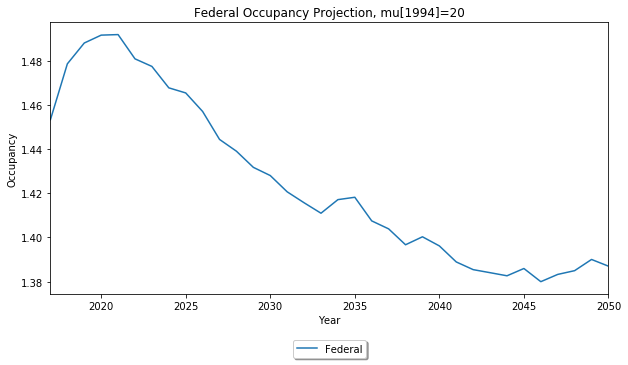

<Figure size 720x360 with 0 Axes>

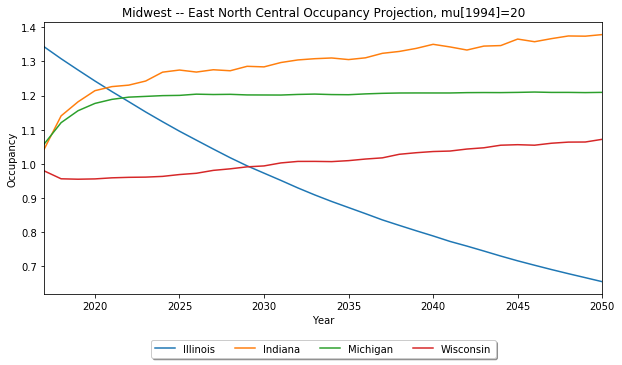

<Figure size 720x360 with 0 Axes>

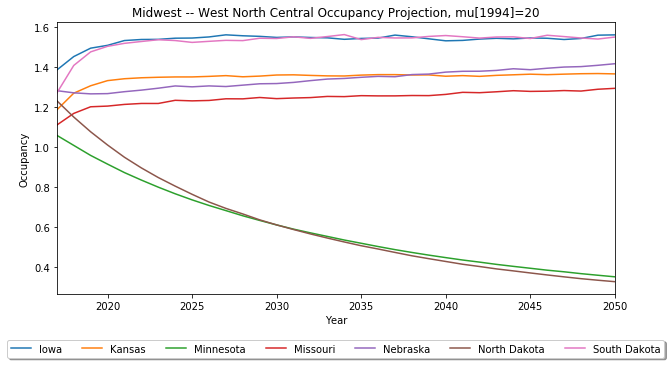

<Figure size 720x360 with 0 Axes>

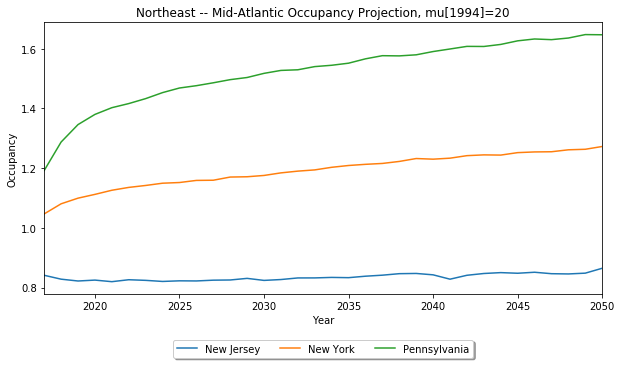

<Figure size 720x360 with 0 Axes>

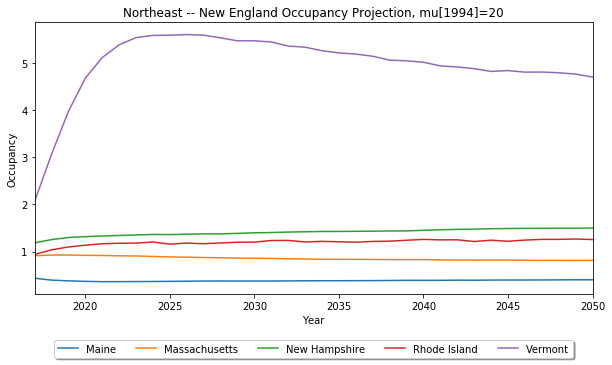

<Figure size 720x360 with 0 Axes>

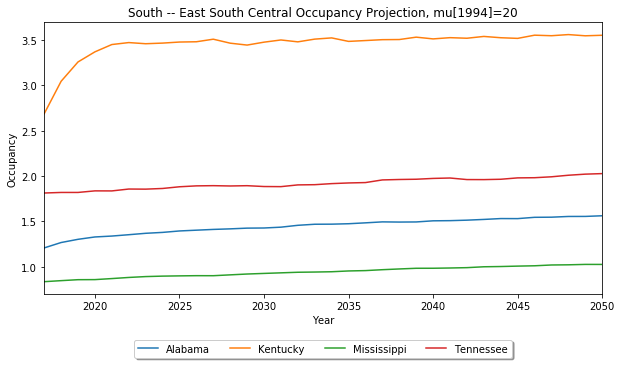

<Figure size 720x360 with 0 Axes>

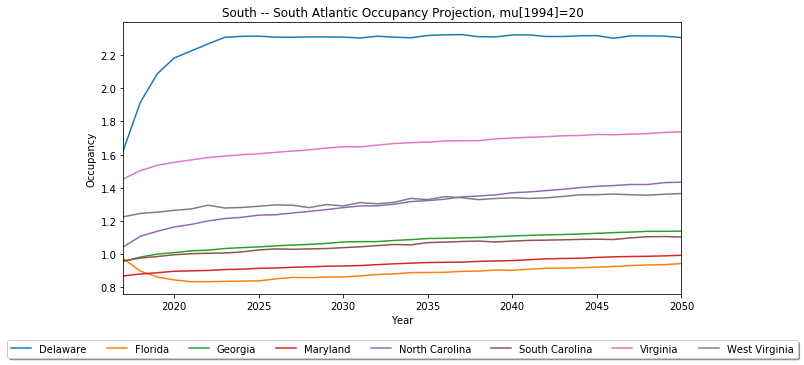

<Figure size 720x360 with 0 Axes>

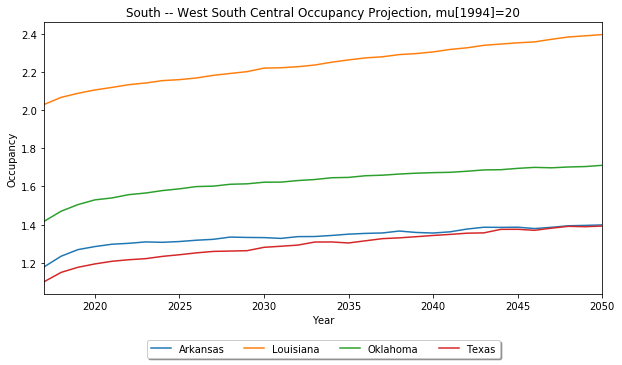

<Figure size 720x360 with 0 Axes>

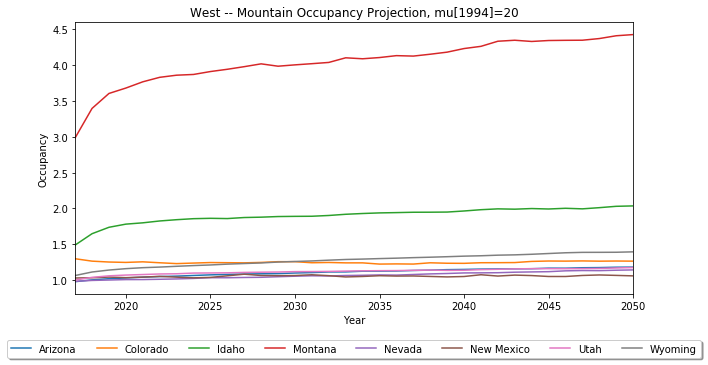

<Figure size 720x360 with 0 Axes>

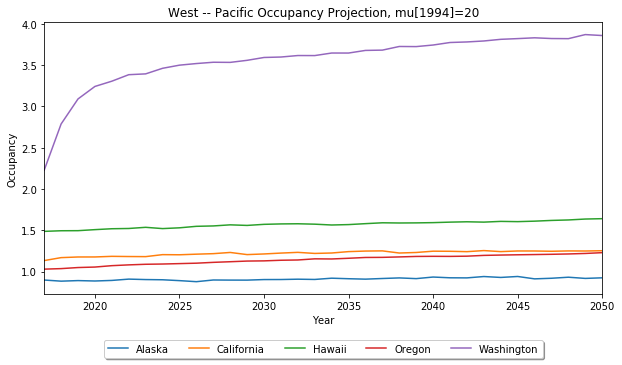

In [60]:
plotOccupancyProjection(futureOccupancyMean_20,futureOccupancySD_20, 20)

The federal prison occupancy will reach its peak level just shy of 150% by early 2020s, before entering a decrease. While most states will suffer a moderate increase of prison occupancy and be forced to function at a relatively over-crowded capacity if no new facility is to be built, the prison occupancy rate of Vermont will rise very drastically to above 500% by 2025. On the other hand, we can expect the occupancy in Illinois, Minnesota and North Dakota to reduce significantly to the level below 100%.

In [61]:
crossingupYear, crossingdownYear = checkOccupancyThresholdCrossing(futureOccupancies_20, 1.5,1, 20)

mu[1994] = 20
--------------------
Year when occupancy rises above 1.5:
Kentucky        2017
Louisiana       2017
Montana         2017
Tennessee       2017
Vermont         2017
Washington      2017
Delaware        2018
Idaho           2018
Iowa            2020
South Dakota    2021
Virginia        2039
Oklahoma        2040
dtype: int64
--------------------
Year when occupancy drops below 1:
Alaska            2017
South Carolina    2017
Rhode Island      2017
Oregon            2017
New Jersey        2017
Nevada            2017
Mississippi       2017
Utah              2017
Wisconsin         2017
Maryland          2017
Maine             2017
Indiana           2017
Georgia           2017
Florida           2017
Arizona           2017
Massachusetts     2017
Minnesota         2019
North Dakota      2021
Illinois          2032
dtype: int64


The analysis indicates that the occupancy rate of prisons in Iowa, South Dakota, Virginia and Oklahoma will rise over 150% within the next two decades while the prison systems in 8 other states have already been too full.

On the other hand, the analysis identifies 16 states that do not currently suffer from an over-crowded prison system. If the current trend continues, even without building new facilities, the occupancy rates in Minnesota, North Dakota and Illinois will fall below 100% in the near future.

# Conclusion

It is recommended that new prisons be built in Kentucky, Lousiana, Montana, Tennessee, Vermont, Washington, Deleware, Idaho, Iowa and South Dakota as the need there is very imminent. More engagement with the justuce system of Virginia and Oklahoma is also encouraged in the future as the prison occupancy rate there are still rising, and the facilities will become over-crowded by late 2030s.

In Alaska, South Carolina, Rhode Island, Oregon, New Jersey, Nevada, Mississippi, Utah, Maryland, Maine, Indiana, Georgia, Florida, Arizona, Massachusetts and Minnesota, there seems to be no market for the private prison industry to expand. As the prison occupancy rate in North Dokota will drop below 100% in early 2020s, future investment plan in that state should hold off. Although the market for private prisons is still existent in Illinois for now, investors should expect significant contranction by early 2030s.

# Discussion

## Average annual sentencing data

In this project, the national sentencing data is used for modelling individual jurisdictions. Ideally, each jurisdiction should adopt its own data because the national data does not account for the variance among the states. Using national data may create more problems especially for jurisdictions with relatively smaller prison populaiton and admission for their sentencing statistics should be a lot less stable than larger populations'. However, only the national data have been made readily available by the U.S. Sentencing Comission.

## Impact of varying $\mu[1994]$

In [62]:
totalFuturePopulationMean_5,totalFuturePopulationSD_5, totalFutureAdmissionMean_5,totalFutureAdmissionSD_5, totalFutureReleaseMean_5,totalFutureReleaseSD_5 = modelAndProjectPopulation_NSamples(totalPrisonerPopulation, totalAdmission,totalRelease, annualSentence, 5, 2050, 250)
totalFuturePopulationMean_10,totalFuturePopulationSD_10, totalFutureAdmissionMean_10,totalFutureAdmissionSD_10, totalFutureReleaseMean_10,totalFutureReleaseSD_10 = modelAndProjectPopulation_NSamples(totalPrisonerPopulation, totalAdmission,totalRelease, annualSentence, 10, 2050, 250)
totalFuturePopulationMean_20,totalFuturePopulationSD_20, totalFutureAdmissionMean_20,totalFutureAdmissionSD_20, totalFutureReleaseMean_20,totalFutureReleaseSD_20 = modelAndProjectPopulation_NSamples(totalPrisonerPopulation, totalAdmission,totalRelease, annualSentence, 20, 2050, 250)
totalFuturePopulationMean_40,totalFuturePopulationSD_40, totalFutureAdmissionMean_40,totalFutureAdmissionSD_40, totalFutureReleaseMean_40,totalFutureReleaseSD_40 = modelAndProjectPopulation_NSamples(totalPrisonerPopulation, totalAdmission,totalRelease, annualSentence, 40, 2050, 250)

In [63]:
def plotFederalProjection_Population(population, futurePopulations,initialMus, maxPopulation):
        
    population.plot(color="grey", label="")
    for i, futurePopulation in enumerate(futurePopulations):
        futurePopulation[2016] = population[2016]
        futurePopulation.sort_index(inplace=True)
        futurePopulation.plot(label = initialMus[i])
    
    plt.axvline(1995, color="grey")
    
    plt.legend(loc="upper left", title="mu[1994]")
    plt.ylim([0, maxPopulation])
    plt.ylabel("Head Count")
    plt.title("Projection of Federal Prisoner Population, varying mu[1994]")
    
    plt.show()

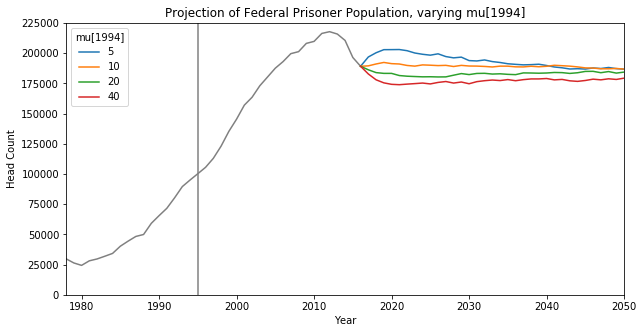

In [64]:
totalFederalPopulationProjections = [totalFuturePopulationMean_5.loc["Federal"], totalFuturePopulationMean_10.loc["Federal"], totalFuturePopulationMean_20.loc["Federal"], totalFuturePopulationMean_40.loc["Federal"]]
plotFederalProjection_Population(totalPrisonerPopulation.loc["Federal"], totalFederalPopulationProjections,[5, 10, 20, 40], 225000)

Because no data is available for establishing a reasonable guess for the initial state of $\mu [t]$, several values have been tested ($\mu [1994] = 5,10,20,40)$. Eventually, 20 seems to be the best guess for several reasons. 

First of all, 20 seems to be a rational value due to practical constraints. As prisoners with short sentences get released sooner, the average remaining sentence of the prisoner population body is unlikely to be a small number, such as 5. Because human lifespan is limited, the center of the distribution should not be a very large number, such as 40, either.

Secondly, the simulation results suggest that, as shown in the figure above, the transition between existing data points and projection is rendered more naturally when $\mu [1994] = 20$. Although from a long-term perpective trajectories with $\mu [1994]$ less than 20 seem to converge very closely to the $\mu [1994] = 20$ trajectory, their transition from data to prediction seems very coerced. This is because in the modelling process, if the center of the distribution is under-estimated, but the cummulative distribution function has to satisfy $r [t] = F(1;\mu [t - 1],{\sigma ^2})p[t - 1]$, the algorithm will have to under-estimate the variance as well. The under-estimated variance can cause the algorithm to under estimate the release number in the projection stage, thus generating a surge in popultion.

## Future work

Future work should focus on collecting more data which would help build a more realistic model. 

More research is needed to generate a reasonable guess of $\mu [1994]$ which can be backed by evidence. Currently, the simulation is based on many assumptions of normal distributions, especially the one that describes the remaining sentence of individual prisoners. If more survey is conducted, it might become possible to build a more faithful model for the distribution of remaining sentence, which can lead to more realistic projections of the release number.

It is also necessary to collect anual sentencing data of the newly admitted prisoners in each state. The reason is twofold. First, state-specific data provides more accuracy. Secondly, currently the lack of sufficient data makes it impossible to generalize a tendency of more lenient sentencing. If data from most states all indicate a similar pattern, it can support a model that predicts a gradually more lenient sentencing.